# GAN example

In [1]:
# import necessary packages


import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
noise_dim = 100 

In [3]:
# creating the dataset of real images
size = 32

def create_images_vert(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(10):
            x0 = random.randrange(5,size-5)
            sample = cv2.line(sample,(x0,0),(x0,size-1),(255,255,255),1)
        #sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        #sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def create_images_diag(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(3):
            x0 = random.randrange(-size/2,size/2)
            sample = cv2.line(sample,(x0,0),(x0+32,32),(255,255,255),2)
        sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def load_images(dir):
    samples = []
    for image_file in os.listdir(dir):
        if image_file.endswith("jpg"):
            sample = cv2.imread(f"{dir}/{image_file}")
            sample = cv2.resize(sample, (32,32))
            sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
            sample = np.expand_dims(sample,axis=2)
            samples.append(sample)
    return samples

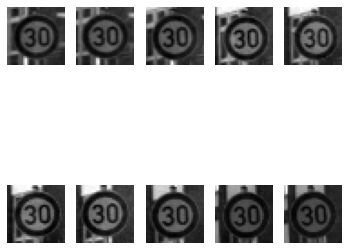

In [17]:
#samples = create_images_diag(1000)
#samples = create_images_vert(1000)
samples = load_images('signs')
samples = np.array(samples)
samples = samples/255

plt.figure(figsize=(6, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i][:,:,0],cmap='gray')
    #plt.title(labels[i])
    plt.axis("off")

In [5]:
# Generator gets a noise vector of size noise_dim and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible

def make_generator_model():
    model = Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))

    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)) 
    
    #model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 8 x 8 x 128

    model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest"))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    #model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 16 x 16 x 64

    model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest"))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    #model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # output: 32 x 32 x 1 (our image)

    model.summary()
    return model
generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [6]:
# Discriminator gets image of size (32 x 32 x 1) and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #model.add(Dense(1))
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [7]:
# returns randomly choosen n samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)    

    return new_samples

In [8]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [9]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    #noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator(input_noise, training=True)
        # evaluate fake images
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Epoch",epoch,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

Epoch 0 g_loss= 0.47443062 d_loss= 4.9506183 real_acc= 0.2 fake_acc= 0.2


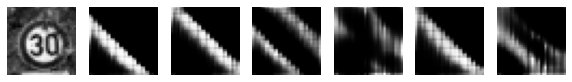

Epoch 1 g_loss= 0.09263113 d_loss= 3.8838181 real_acc= 0.32 fake_acc= 0.0
Epoch 2 g_loss= 0.037592586 d_loss= 1.8947622 real_acc= 0.86 fake_acc= 0.0
Epoch 3 g_loss= 0.05586944 d_loss= 1.5348408 real_acc= 1.0 fake_acc= 0.0
Epoch 4 g_loss= 0.19066013 d_loss= 0.9919327 real_acc= 1.0 fake_acc= 0.0
Epoch 5 g_loss= 0.73358417 d_loss= 0.44369784 real_acc= 1.0 fake_acc= 0.54
Epoch 6 g_loss= 1.7764103 d_loss= 0.18941346 real_acc= 1.0 fake_acc= 0.86
Epoch 7 g_loss= 3.1802883 d_loss= 0.05343265 real_acc= 1.0 fake_acc= 1.0
Epoch 8 g_loss= 4.504357 d_loss= 0.009619905 real_acc= 1.0 fake_acc= 1.0
Epoch 9 g_loss= 5.0726 d_loss= 0.029317264 real_acc= 0.98 fake_acc= 1.0
Epoch 10 g_loss= 5.475487 d_loss= 0.037811585 real_acc= 0.98 fake_acc= 0.98


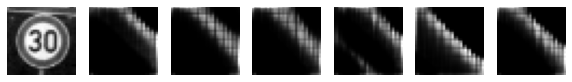

Epoch 11 g_loss= 4.75215 d_loss= 0.039511576 real_acc= 0.98 fake_acc= 1.0
Epoch 12 g_loss= 3.6140094 d_loss= 0.11627493 real_acc= 0.96 fake_acc= 0.98
Epoch 13 g_loss= 2.1173801 d_loss= 0.26089966 real_acc= 0.98 fake_acc= 0.76
Epoch 14 g_loss= 1.3369164 d_loss= 0.7242595 real_acc= 0.92 fake_acc= 0.46
Epoch 15 g_loss= 1.6366574 d_loss= 0.85415095 real_acc= 0.9 fake_acc= 0.4
Epoch 16 g_loss= 1.7090003 d_loss= 0.7771564 real_acc= 0.94 fake_acc= 0.52
Epoch 17 g_loss= 3.2680612 d_loss= 0.9625187 real_acc= 0.68 fake_acc= 0.78
Epoch 18 g_loss= 4.962427 d_loss= 1.053002 real_acc= 0.56 fake_acc= 0.9
Epoch 19 g_loss= 5.7946997 d_loss= 1.3066278 real_acc= 0.38 fake_acc= 1.0
Epoch 20 g_loss= 5.6866374 d_loss= 1.2269135 real_acc= 0.48 fake_acc= 0.86


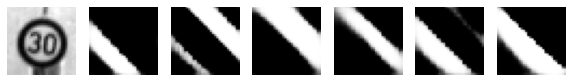

Epoch 21 g_loss= 4.6788707 d_loss= 1.0685109 real_acc= 0.54 fake_acc= 0.9
Epoch 22 g_loss= 3.6841943 d_loss= 0.54160786 real_acc= 0.7 fake_acc= 0.86
Epoch 23 g_loss= 2.5765347 d_loss= 0.7325487 real_acc= 0.84 fake_acc= 0.7
Epoch 24 g_loss= 2.00131 d_loss= 0.72523147 real_acc= 0.88 fake_acc= 0.58
Epoch 25 g_loss= 2.7093875 d_loss= 0.80319613 real_acc= 0.92 fake_acc= 0.7
Epoch 26 g_loss= 2.5652719 d_loss= 0.6236057 real_acc= 0.88 fake_acc= 0.7
Epoch 27 g_loss= 3.7357485 d_loss= 0.42933747 real_acc= 0.84 fake_acc= 0.82
Epoch 28 g_loss= 4.949465 d_loss= 0.2856067 real_acc= 0.86 fake_acc= 0.92
Epoch 29 g_loss= 5.824297 d_loss= 0.210026 real_acc= 0.78 fake_acc= 1.0
Epoch 30 g_loss= 6.889543 d_loss= 0.5184132 real_acc= 0.82 fake_acc= 1.0


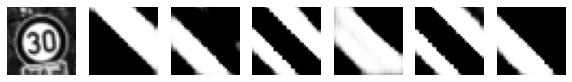

Epoch 31 g_loss= 7.930313 d_loss= 0.43102396 real_acc= 0.64 fake_acc= 1.0
Epoch 32 g_loss= 7.90739 d_loss= 0.34750596 real_acc= 0.78 fake_acc= 1.0
Epoch 33 g_loss= 7.3757033 d_loss= 0.2960924 real_acc= 0.84 fake_acc= 1.0
Epoch 34 g_loss= 6.724402 d_loss= 0.18318944 real_acc= 0.92 fake_acc= 1.0
Epoch 35 g_loss= 5.5889416 d_loss= 0.20199622 real_acc= 0.92 fake_acc= 1.0
Epoch 36 g_loss= 5.2911353 d_loss= 0.10615521 real_acc= 0.88 fake_acc= 1.0
Epoch 37 g_loss= 4.65415 d_loss= 0.12629849 real_acc= 0.98 fake_acc= 0.92
Epoch 38 g_loss= 3.9872942 d_loss= 0.09335461 real_acc= 1.0 fake_acc= 0.92
Epoch 39 g_loss= 3.8955681 d_loss= 0.1609596 real_acc= 0.96 fake_acc= 0.9
Epoch 40 g_loss= 4.355086 d_loss= 0.06305321 real_acc= 1.0 fake_acc= 0.96


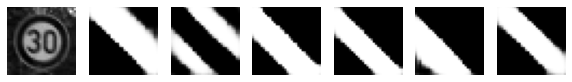

Epoch 41 g_loss= 3.903579 d_loss= 0.17166594 real_acc= 1.0 fake_acc= 0.94
Epoch 42 g_loss= 3.9306238 d_loss= 0.12896276 real_acc= 1.0 fake_acc= 0.88
Epoch 43 g_loss= 5.0485244 d_loss= 0.0521396 real_acc= 1.0 fake_acc= 0.96
Epoch 44 g_loss= 5.5738177 d_loss= 0.069578804 real_acc= 1.0 fake_acc= 0.96
Epoch 45 g_loss= 6.5252285 d_loss= 0.05764193 real_acc= 1.0 fake_acc= 0.98
Epoch 46 g_loss= 7.357301 d_loss= 0.07458139 real_acc= 0.96 fake_acc= 1.0
Epoch 47 g_loss= 7.233856 d_loss= 0.09133063 real_acc= 0.96 fake_acc= 0.98
Epoch 48 g_loss= 7.797842 d_loss= 0.11562501 real_acc= 0.96 fake_acc= 0.98
Epoch 49 g_loss= 7.3997912 d_loss= 0.10190061 real_acc= 0.94 fake_acc= 1.0
Epoch 50 g_loss= 6.4532757 d_loss= 0.10862207 real_acc= 0.96 fake_acc= 1.0


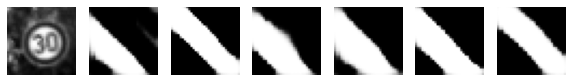

Epoch 51 g_loss= 6.04214 d_loss= 0.20676512 real_acc= 1.0 fake_acc= 0.88
Epoch 52 g_loss= 6.170181 d_loss= 0.13825712 real_acc= 0.94 fake_acc= 0.96
Epoch 53 g_loss= 5.168047 d_loss= 0.11093856 real_acc= 0.96 fake_acc= 0.9
Epoch 54 g_loss= 4.6282597 d_loss= 0.3267262 real_acc= 0.96 fake_acc= 0.86
Epoch 55 g_loss= 4.9661574 d_loss= 0.18677443 real_acc= 0.96 fake_acc= 0.92
Epoch 56 g_loss= 6.0695076 d_loss= 0.15568109 real_acc= 0.92 fake_acc= 0.94
Epoch 57 g_loss= 5.6688147 d_loss= 0.21552196 real_acc= 0.9 fake_acc= 0.92
Epoch 58 g_loss= 7.171221 d_loss= 0.2393762 real_acc= 0.92 fake_acc= 0.96
Epoch 59 g_loss= 6.39277 d_loss= 0.32591057 real_acc= 0.92 fake_acc= 0.94
Epoch 60 g_loss= 6.3322597 d_loss= 0.30816227 real_acc= 0.9 fake_acc= 0.94


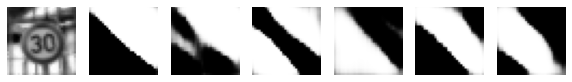

Epoch 61 g_loss= 4.4056063 d_loss= 0.3102798 real_acc= 0.94 fake_acc= 0.84
Epoch 62 g_loss= 4.2045507 d_loss= 0.43908423 real_acc= 0.94 fake_acc= 0.78
Epoch 63 g_loss= 4.793159 d_loss= 0.24404193 real_acc= 1.0 fake_acc= 0.9
Epoch 64 g_loss= 4.7689605 d_loss= 0.21327452 real_acc= 0.92 fake_acc= 0.94
Epoch 65 g_loss= 7.268556 d_loss= 0.23043633 real_acc= 0.82 fake_acc= 1.0
Epoch 66 g_loss= 6.3043284 d_loss= 0.2042819 real_acc= 0.88 fake_acc= 0.94
Epoch 67 g_loss= 5.2838826 d_loss= 0.29184312 real_acc= 0.98 fake_acc= 0.88
Epoch 68 g_loss= 4.7226343 d_loss= 0.2749487 real_acc= 0.98 fake_acc= 0.9
Epoch 69 g_loss= 5.5017834 d_loss= 0.22987266 real_acc= 0.92 fake_acc= 0.9
Epoch 70 g_loss= 4.9910693 d_loss= 0.28479713 real_acc= 0.92 fake_acc= 0.86


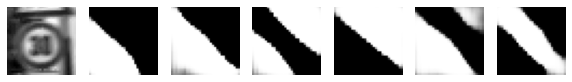

Epoch 71 g_loss= 7.0827208 d_loss= 0.22068222 real_acc= 0.86 fake_acc= 0.98
Epoch 72 g_loss= 6.680453 d_loss= 0.17413332 real_acc= 0.92 fake_acc= 0.94
Epoch 73 g_loss= 4.5925083 d_loss= 0.22656745 real_acc= 0.94 fake_acc= 0.9
Epoch 74 g_loss= 5.4571896 d_loss= 0.11988254 real_acc= 0.98 fake_acc= 0.88
Epoch 75 g_loss= 5.312112 d_loss= 0.1662437 real_acc= 0.92 fake_acc= 0.9
Epoch 76 g_loss= 6.4615197 d_loss= 0.21459837 real_acc= 0.9 fake_acc= 0.94
Epoch 77 g_loss= 7.3253646 d_loss= 0.112257086 real_acc= 0.94 fake_acc= 0.98
Epoch 78 g_loss= 7.2765284 d_loss= 0.18938208 real_acc= 0.82 fake_acc= 1.0
Epoch 79 g_loss= 5.811774 d_loss= 0.11305834 real_acc= 0.98 fake_acc= 0.88
Epoch 80 g_loss= 4.68206 d_loss= 0.14350696 real_acc= 1.0 fake_acc= 0.88


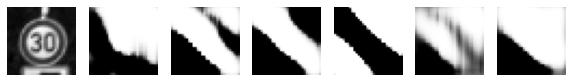

Epoch 81 g_loss= 5.0992393 d_loss= 0.13151586 real_acc= 0.98 fake_acc= 0.9
Epoch 82 g_loss= 6.144202 d_loss= 0.11333929 real_acc= 1.0 fake_acc= 0.88
Epoch 83 g_loss= 8.164181 d_loss= 0.10642934 real_acc= 0.9 fake_acc= 1.0
Epoch 84 g_loss= 9.015048 d_loss= 0.2762623 real_acc= 0.76 fake_acc= 1.0
Epoch 85 g_loss= 6.413595 d_loss= 0.07869626 real_acc= 0.96 fake_acc= 1.0
Epoch 86 g_loss= 3.9571009 d_loss= 0.33045056 real_acc= 0.98 fake_acc= 0.76
Epoch 87 g_loss= 4.005165 d_loss= 0.29164466 real_acc= 1.0 fake_acc= 0.82
Epoch 88 g_loss= 5.4310975 d_loss= 0.05596774 real_acc= 1.0 fake_acc= 1.0
Epoch 89 g_loss= 8.321534 d_loss= 0.095340945 real_acc= 0.9 fake_acc= 1.0
Epoch 90 g_loss= 10.137337 d_loss= 0.2711594 real_acc= 0.72 fake_acc= 1.0


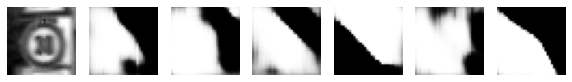

Epoch 91 g_loss= 7.9079137 d_loss= 0.11218503 real_acc= 0.94 fake_acc= 0.98
Epoch 92 g_loss= 5.4232965 d_loss= 0.073273145 real_acc= 1.0 fake_acc= 0.96
Epoch 93 g_loss= 4.2527766 d_loss= 0.2173288 real_acc= 1.0 fake_acc= 0.86
Epoch 94 g_loss= 4.7582164 d_loss= 0.19881463 real_acc= 0.98 fake_acc= 0.9
Epoch 95 g_loss= 6.9138856 d_loss= 0.09836467 real_acc= 0.96 fake_acc= 0.98
Epoch 96 g_loss= 9.640577 d_loss= 0.084333785 real_acc= 0.88 fake_acc= 1.0
Epoch 97 g_loss= 9.456943 d_loss= 0.37492272 real_acc= 0.68 fake_acc= 1.0
Epoch 98 g_loss= 6.5090985 d_loss= 0.06514322 real_acc= 0.96 fake_acc= 1.0
Epoch 99 g_loss= 3.3946912 d_loss= 0.242937 real_acc= 0.96 fake_acc= 0.88
Epoch 100 g_loss= 2.5990307 d_loss= 0.56955636 real_acc= 0.98 fake_acc= 0.68


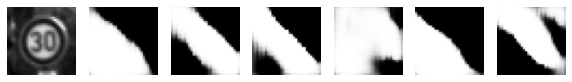

Epoch 101 g_loss= 4.0314937 d_loss= 0.29488298 real_acc= 0.98 fake_acc= 0.84
Epoch 102 g_loss= 7.7537737 d_loss= 0.08829963 real_acc= 0.88 fake_acc= 1.0
Epoch 103 g_loss= 10.050382 d_loss= 0.23389016 real_acc= 0.8 fake_acc= 1.0
Epoch 104 g_loss= 11.201398 d_loss= 0.24489436 real_acc= 0.84 fake_acc= 1.0
Epoch 105 g_loss= 10.153918 d_loss= 0.12357227 real_acc= 0.88 fake_acc= 1.0
Epoch 106 g_loss= 6.7926435 d_loss= 0.049098026 real_acc= 1.0 fake_acc= 0.96
Epoch 107 g_loss= 5.608917 d_loss= 0.14377654 real_acc= 0.96 fake_acc= 0.9
Epoch 108 g_loss= 4.977145 d_loss= 0.11046109 real_acc= 1.0 fake_acc= 0.94
Epoch 109 g_loss= 4.7240267 d_loss= 0.14669383 real_acc= 0.98 fake_acc= 0.94
Epoch 110 g_loss= 5.079842 d_loss= 0.05676306 real_acc= 1.0 fake_acc= 0.96


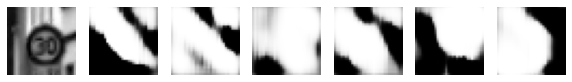

Epoch 111 g_loss= 6.5421944 d_loss= 0.03949789 real_acc= 0.96 fake_acc= 1.0
Epoch 112 g_loss= 7.40629 d_loss= 0.06886086 real_acc= 0.94 fake_acc= 1.0
Epoch 113 g_loss= 7.47854 d_loss= 0.026666403 real_acc= 0.98 fake_acc= 1.0
Epoch 114 g_loss= 6.8470006 d_loss= 0.035802707 real_acc= 1.0 fake_acc= 1.0
Epoch 115 g_loss= 6.4986134 d_loss= 0.03261674 real_acc= 1.0 fake_acc= 0.98
Epoch 116 g_loss= 6.2849903 d_loss= 0.030159328 real_acc= 0.96 fake_acc= 1.0
Epoch 117 g_loss= 6.4992833 d_loss= 0.04137916 real_acc= 1.0 fake_acc= 1.0
Epoch 118 g_loss= 5.538104 d_loss= 0.05234643 real_acc= 1.0 fake_acc= 0.96
Epoch 119 g_loss= 5.9778576 d_loss= 0.09086753 real_acc= 0.98 fake_acc= 0.94
Epoch 120 g_loss= 6.257242 d_loss= 0.02538133 real_acc= 1.0 fake_acc= 1.0


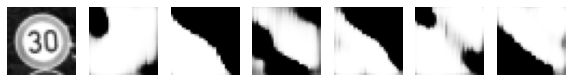

Epoch 121 g_loss= 7.725693 d_loss= 0.04492532 real_acc= 0.96 fake_acc= 1.0
Epoch 122 g_loss= 7.4262476 d_loss= 0.033254087 real_acc= 0.96 fake_acc= 1.0
Epoch 123 g_loss= 7.1349916 d_loss= 0.03058363 real_acc= 0.98 fake_acc= 1.0
Epoch 124 g_loss= 6.1100864 d_loss= 0.0454395 real_acc= 1.0 fake_acc= 1.0
Epoch 125 g_loss= 5.380081 d_loss= 0.078278355 real_acc= 0.96 fake_acc= 0.96
Epoch 126 g_loss= 5.5055237 d_loss= 0.06648885 real_acc= 0.98 fake_acc= 0.96
Epoch 127 g_loss= 6.2223754 d_loss= 0.035330977 real_acc= 1.0 fake_acc= 1.0
Epoch 128 g_loss= 5.836577 d_loss= 0.040309183 real_acc= 0.98 fake_acc= 1.0
Epoch 129 g_loss= 6.1170764 d_loss= 0.023178916 real_acc= 1.0 fake_acc= 1.0
Epoch 130 g_loss= 6.476157 d_loss= 0.029578837 real_acc= 0.98 fake_acc= 1.0


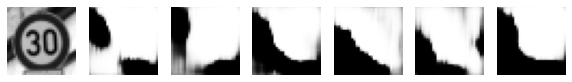

Epoch 131 g_loss= 6.69077 d_loss= 0.043208607 real_acc= 0.96 fake_acc= 1.0
Epoch 132 g_loss= 5.7603745 d_loss= 0.03497711 real_acc= 1.0 fake_acc= 1.0
Epoch 133 g_loss= 5.2789335 d_loss= 0.05625826 real_acc= 0.98 fake_acc= 0.96
Epoch 134 g_loss= 5.493278 d_loss= 0.045617267 real_acc= 0.98 fake_acc= 1.0
Epoch 135 g_loss= 5.245232 d_loss= 0.037661865 real_acc= 1.0 fake_acc= 1.0
Epoch 136 g_loss= 5.142992 d_loss= 0.054328524 real_acc= 0.98 fake_acc= 1.0
Epoch 137 g_loss= 6.141273 d_loss= 0.03173965 real_acc= 1.0 fake_acc= 0.98
Epoch 138 g_loss= 6.3386846 d_loss= 0.022094551 real_acc= 1.0 fake_acc= 0.98
Epoch 139 g_loss= 7.3364882 d_loss= 0.14606231 real_acc= 0.9 fake_acc= 1.0
Epoch 140 g_loss= 5.9394145 d_loss= 0.03422263 real_acc= 0.98 fake_acc= 1.0


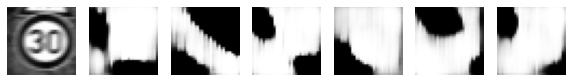

Epoch 141 g_loss= 5.429219 d_loss= 0.04070676 real_acc= 1.0 fake_acc= 0.98
Epoch 142 g_loss= 4.5907025 d_loss= 0.041346192 real_acc= 1.0 fake_acc= 0.98
Epoch 143 g_loss= 4.711434 d_loss= 0.03384327 real_acc= 1.0 fake_acc= 0.98
Epoch 144 g_loss= 4.9176774 d_loss= 0.05976805 real_acc= 0.98 fake_acc= 0.98
Epoch 145 g_loss= 5.5655937 d_loss= 0.0565056 real_acc= 0.98 fake_acc= 0.98
Epoch 146 g_loss= 5.354485 d_loss= 0.06653028 real_acc= 0.96 fake_acc= 1.0
Epoch 147 g_loss= 5.4920864 d_loss= 0.055057045 real_acc= 0.98 fake_acc= 1.0
Epoch 148 g_loss= 4.2811766 d_loss= 0.049961418 real_acc= 1.0 fake_acc= 0.96
Epoch 149 g_loss= 4.674934 d_loss= 0.029160505 real_acc= 1.0 fake_acc= 1.0
Epoch 150 g_loss= 5.09263 d_loss= 0.042229738 real_acc= 1.0 fake_acc= 0.98


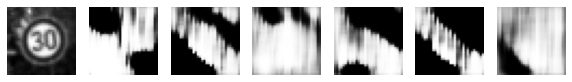

Epoch 151 g_loss= 5.162546 d_loss= 0.073087946 real_acc= 0.94 fake_acc= 1.0
Epoch 152 g_loss= 5.8416805 d_loss= 0.10507696 real_acc= 0.94 fake_acc= 1.0
Epoch 153 g_loss= 5.0919647 d_loss= 0.028240412 real_acc= 1.0 fake_acc= 1.0
Epoch 154 g_loss= 3.9350617 d_loss= 0.06846439 real_acc= 1.0 fake_acc= 0.96
Epoch 155 g_loss= 4.255933 d_loss= 0.06321096 real_acc= 0.98 fake_acc= 0.98
Epoch 156 g_loss= 3.409377 d_loss= 0.094919585 real_acc= 0.98 fake_acc= 0.94
Epoch 157 g_loss= 3.8021514 d_loss= 0.10949074 real_acc= 0.94 fake_acc= 0.98
Epoch 158 g_loss= 5.0475545 d_loss= 0.11295393 real_acc= 0.92 fake_acc= 0.98
Epoch 159 g_loss= 4.8114157 d_loss= 0.07312599 real_acc= 0.96 fake_acc= 0.98
Epoch 160 g_loss= 4.369463 d_loss= 0.050065763 real_acc= 0.98 fake_acc= 1.0


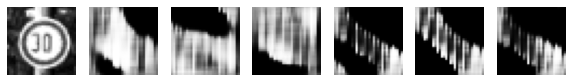

Epoch 161 g_loss= 3.804499 d_loss= 0.08349842 real_acc= 0.94 fake_acc= 1.0
Epoch 162 g_loss= 3.558612 d_loss= 0.133948 real_acc= 0.98 fake_acc= 0.9
Epoch 163 g_loss= 3.785227 d_loss= 0.09026038 real_acc= 0.98 fake_acc= 0.98
Epoch 164 g_loss= 3.5363202 d_loss= 0.11136083 real_acc= 1.0 fake_acc= 0.92
Epoch 165 g_loss= 3.6705434 d_loss= 0.12533125 real_acc= 0.94 fake_acc= 0.96
Epoch 166 g_loss= 4.1770635 d_loss= 0.13088831 real_acc= 0.92 fake_acc= 1.0
Epoch 167 g_loss= 4.019785 d_loss= 0.20528653 real_acc= 0.92 fake_acc= 0.92
Epoch 168 g_loss= 3.2896528 d_loss= 0.20108694 real_acc= 0.92 fake_acc= 0.94
Epoch 169 g_loss= 2.584558 d_loss= 0.20286322 real_acc= 0.9 fake_acc= 0.88
Epoch 170 g_loss= 2.1452339 d_loss= 0.21715859 real_acc= 1.0 fake_acc= 0.82


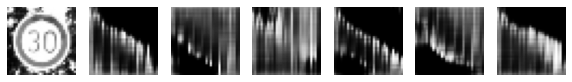

Epoch 171 g_loss= 3.007209 d_loss= 0.3684106 real_acc= 0.82 fake_acc= 0.78
Epoch 172 g_loss= 3.2845569 d_loss= 0.3149879 real_acc= 0.86 fake_acc= 0.86
Epoch 173 g_loss= 3.4771175 d_loss= 0.3157929 real_acc= 0.94 fake_acc= 0.8
Epoch 174 g_loss= 3.4551318 d_loss= 0.30885646 real_acc= 0.96 fake_acc= 0.82
Epoch 175 g_loss= 4.077222 d_loss= 0.22356841 real_acc= 0.96 fake_acc= 0.8
Epoch 176 g_loss= 3.6491346 d_loss= 0.3858379 real_acc= 0.84 fake_acc= 0.9
Epoch 177 g_loss= 4.1438084 d_loss= 0.35557428 real_acc= 0.86 fake_acc= 0.82
Epoch 178 g_loss= 3.3527353 d_loss= 0.38545537 real_acc= 0.9 fake_acc= 0.78
Epoch 179 g_loss= 3.6733978 d_loss= 0.4607069 real_acc= 0.9 fake_acc= 0.72
Epoch 180 g_loss= 3.748606 d_loss= 0.2761103 real_acc= 0.9 fake_acc= 0.88


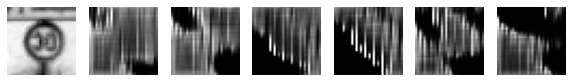

Epoch 181 g_loss= 3.8902543 d_loss= 0.5052121 real_acc= 0.9 fake_acc= 0.74
Epoch 182 g_loss= 3.9177997 d_loss= 0.31719366 real_acc= 0.92 fake_acc= 0.8
Epoch 183 g_loss= 3.9349203 d_loss= 0.37152678 real_acc= 0.92 fake_acc= 0.82
Epoch 184 g_loss= 4.5985737 d_loss= 0.31322318 real_acc= 0.94 fake_acc= 0.82
Epoch 185 g_loss= 4.549428 d_loss= 0.41246635 real_acc= 0.82 fake_acc= 0.76
Epoch 186 g_loss= 4.5724864 d_loss= 0.26609907 real_acc= 0.86 fake_acc= 0.92
Epoch 187 g_loss= 3.9861236 d_loss= 0.4233017 real_acc= 0.88 fake_acc= 0.72
Epoch 188 g_loss= 3.9498131 d_loss= 0.44224277 real_acc= 0.9 fake_acc= 0.78
Epoch 189 g_loss= 3.8773742 d_loss= 0.44821203 real_acc= 0.88 fake_acc= 0.82
Epoch 190 g_loss= 3.6613755 d_loss= 0.54710865 real_acc= 0.88 fake_acc= 0.78


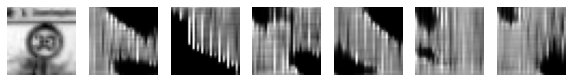

Epoch 191 g_loss= 3.4105499 d_loss= 0.50401276 real_acc= 0.9 fake_acc= 0.76
Epoch 192 g_loss= 4.6501207 d_loss= 0.37401474 real_acc= 0.88 fake_acc= 0.86
Epoch 193 g_loss= 3.8944898 d_loss= 0.34252954 real_acc= 0.9 fake_acc= 0.82
Epoch 194 g_loss= 4.0240517 d_loss= 0.4638307 real_acc= 0.78 fake_acc= 0.86
Epoch 195 g_loss= 4.31216 d_loss= 0.2815017 real_acc= 0.92 fake_acc= 0.9
Epoch 196 g_loss= 3.3084862 d_loss= 0.3919065 real_acc= 0.88 fake_acc= 0.76
Epoch 197 g_loss= 3.3393192 d_loss= 0.3476459 real_acc= 0.9 fake_acc= 0.82
Epoch 198 g_loss= 3.1925285 d_loss= 0.33934343 real_acc= 0.94 fake_acc= 0.78
Epoch 199 g_loss= 2.9191284 d_loss= 0.37292606 real_acc= 0.9 fake_acc= 0.8
Epoch 200 g_loss= 2.9609728 d_loss= 0.38436782 real_acc= 0.86 fake_acc= 0.76


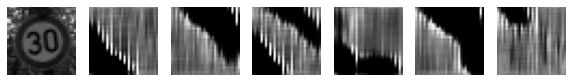

Epoch 201 g_loss= 2.339045 d_loss= 0.3826872 real_acc= 0.92 fake_acc= 0.76
Epoch 202 g_loss= 2.3869584 d_loss= 0.3368755 real_acc= 0.96 fake_acc= 0.8
Epoch 203 g_loss= 2.3894641 d_loss= 0.4247287 real_acc= 0.86 fake_acc= 0.68
Epoch 204 g_loss= 2.6728404 d_loss= 0.3784103 real_acc= 0.84 fake_acc= 0.88
Epoch 205 g_loss= 2.6130128 d_loss= 0.43989903 real_acc= 0.82 fake_acc= 0.8
Epoch 206 g_loss= 2.2867198 d_loss= 0.39480925 real_acc= 0.9 fake_acc= 0.8
Epoch 207 g_loss= 2.3849306 d_loss= 0.37656802 real_acc= 0.94 fake_acc= 0.7
Epoch 208 g_loss= 2.1918015 d_loss= 0.37724125 real_acc= 0.98 fake_acc= 0.7
Epoch 209 g_loss= 2.5360267 d_loss= 0.3626746 real_acc= 0.9 fake_acc= 0.78
Epoch 210 g_loss= 2.6088755 d_loss= 0.2911209 real_acc= 0.92 fake_acc= 0.74


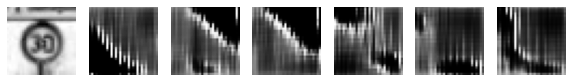

Epoch 211 g_loss= 2.7706878 d_loss= 0.29881257 real_acc= 0.9 fake_acc= 0.9
Epoch 212 g_loss= 3.0902326 d_loss= 0.2634282 real_acc= 0.92 fake_acc= 0.9
Epoch 213 g_loss= 2.9189377 d_loss= 0.3078493 real_acc= 0.86 fake_acc= 0.94
Epoch 214 g_loss= 2.859108 d_loss= 0.21824688 real_acc= 0.96 fake_acc= 0.92
Epoch 215 g_loss= 3.016849 d_loss= 0.21054813 real_acc= 0.9 fake_acc= 0.9
Epoch 216 g_loss= 2.7009168 d_loss= 0.20579928 real_acc= 0.98 fake_acc= 0.92
Epoch 217 g_loss= 3.125865 d_loss= 0.14554545 real_acc= 0.98 fake_acc= 0.96
Epoch 218 g_loss= 2.9241507 d_loss= 0.1703538 real_acc= 0.96 fake_acc= 0.96
Epoch 219 g_loss= 2.9426827 d_loss= 0.1791423 real_acc= 0.98 fake_acc= 0.94
Epoch 220 g_loss= 2.7582684 d_loss= 0.19451785 real_acc= 0.94 fake_acc= 0.9


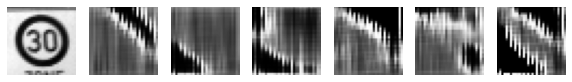

Epoch 221 g_loss= 3.5911527 d_loss= 0.14309576 real_acc= 0.96 fake_acc= 0.98
Epoch 222 g_loss= 3.8491137 d_loss= 0.16962856 real_acc= 0.88 fake_acc= 1.0
Epoch 223 g_loss= 3.425836 d_loss= 0.12686299 real_acc= 0.94 fake_acc= 1.0
Epoch 224 g_loss= 3.2846136 d_loss= 0.15322107 real_acc= 0.94 fake_acc= 0.94
Epoch 225 g_loss= 3.5126913 d_loss= 0.09235433 real_acc= 1.0 fake_acc= 0.98
Epoch 226 g_loss= 3.5565393 d_loss= 0.13534759 real_acc= 0.96 fake_acc= 0.98
Epoch 227 g_loss= 3.756707 d_loss= 0.16965327 real_acc= 0.94 fake_acc= 0.94
Epoch 228 g_loss= 3.5451496 d_loss= 0.1419999 real_acc= 0.98 fake_acc= 0.98
Epoch 229 g_loss= 3.5456958 d_loss= 0.15605223 real_acc= 0.96 fake_acc= 0.94
Epoch 230 g_loss= 3.5705678 d_loss= 0.15671763 real_acc= 0.94 fake_acc= 0.96


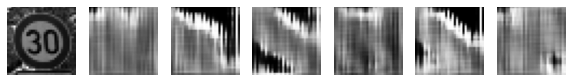

Epoch 231 g_loss= 3.7725842 d_loss= 0.22080502 real_acc= 0.92 fake_acc= 0.98
Epoch 232 g_loss= 3.167453 d_loss= 0.21970932 real_acc= 0.9 fake_acc= 0.84
Epoch 233 g_loss= 3.2284167 d_loss= 0.20962496 real_acc= 0.96 fake_acc= 0.88
Epoch 234 g_loss= 3.4595442 d_loss= 0.20051809 real_acc= 0.88 fake_acc= 0.96
Epoch 235 g_loss= 3.9064562 d_loss= 0.31568128 real_acc= 0.76 fake_acc= 0.9
Epoch 236 g_loss= 3.410683 d_loss= 0.28526017 real_acc= 0.86 fake_acc= 0.92
Epoch 237 g_loss= 2.5591981 d_loss= 0.33625555 real_acc= 0.86 fake_acc= 0.8
Epoch 238 g_loss= 2.612182 d_loss= 0.4757201 real_acc= 0.88 fake_acc= 0.74
Epoch 239 g_loss= 2.4688828 d_loss= 0.36939928 real_acc= 0.9 fake_acc= 0.72
Epoch 240 g_loss= 3.1988297 d_loss= 0.41173893 real_acc= 0.76 fake_acc= 0.88


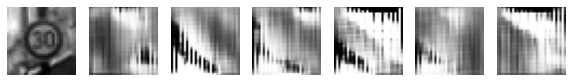

Epoch 241 g_loss= 2.6646557 d_loss= 0.4580406 real_acc= 0.72 fake_acc= 0.88
Epoch 242 g_loss= 2.4913898 d_loss= 0.41309148 real_acc= 0.82 fake_acc= 0.86
Epoch 243 g_loss= 1.5364872 d_loss= 0.38404545 real_acc= 0.94 fake_acc= 0.76
Epoch 244 g_loss= 1.3970627 d_loss= 0.47354287 real_acc= 0.9 fake_acc= 0.68
Epoch 245 g_loss= 2.3137066 d_loss= 0.5150712 real_acc= 0.68 fake_acc= 0.9
Epoch 246 g_loss= 2.6882749 d_loss= 0.7008836 real_acc= 0.6 fake_acc= 0.94
Epoch 247 g_loss= 1.3512763 d_loss= 0.5109184 real_acc= 0.88 fake_acc= 0.58
Epoch 248 g_loss= 1.4881247 d_loss= 0.4728784 real_acc= 0.82 fake_acc= 0.62
Epoch 249 g_loss= 2.287496 d_loss= 0.34624624 real_acc= 0.88 fake_acc= 0.76
Epoch 250 g_loss= 2.676947 d_loss= 0.37542382 real_acc= 0.72 fake_acc= 0.94


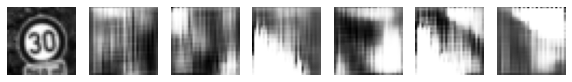

Epoch 251 g_loss= 2.1851354 d_loss= 0.46880627 real_acc= 0.74 fake_acc= 0.78
Epoch 252 g_loss= 1.7074357 d_loss= 0.32389832 real_acc= 0.9 fake_acc= 0.82
Epoch 253 g_loss= 1.9501301 d_loss= 0.36456198 real_acc= 0.94 fake_acc= 0.74
Epoch 254 g_loss= 2.3014677 d_loss= 0.31958348 real_acc= 0.9 fake_acc= 0.84
Epoch 255 g_loss= 3.2443464 d_loss= 0.24292448 real_acc= 0.84 fake_acc= 0.92
Epoch 256 g_loss= 3.3451455 d_loss= 0.36339712 real_acc= 0.74 fake_acc= 0.92
Epoch 257 g_loss= 3.530727 d_loss= 0.24675846 real_acc= 0.86 fake_acc= 0.94
Epoch 258 g_loss= 2.9753873 d_loss= 0.269885 real_acc= 0.88 fake_acc= 0.98
Epoch 259 g_loss= 2.0950396 d_loss= 0.323182 real_acc= 0.94 fake_acc= 0.8
Epoch 260 g_loss= 2.5447986 d_loss= 0.26352817 real_acc= 0.84 fake_acc= 0.94


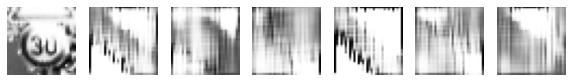

Epoch 261 g_loss= 2.8300707 d_loss= 0.2940498 real_acc= 0.86 fake_acc= 0.9
Epoch 262 g_loss= 3.453064 d_loss= 0.27708402 real_acc= 0.84 fake_acc= 0.92
Epoch 263 g_loss= 3.4404588 d_loss= 0.3132451 real_acc= 0.82 fake_acc= 1.0
Epoch 264 g_loss= 2.7479217 d_loss= 0.28668478 real_acc= 0.94 fake_acc= 0.86
Epoch 265 g_loss= 2.1406658 d_loss= 0.32679373 real_acc= 0.9 fake_acc= 0.82
Epoch 266 g_loss= 3.1022296 d_loss= 0.23750064 real_acc= 0.82 fake_acc= 0.92
Epoch 267 g_loss= 4.0522423 d_loss= 0.26531693 real_acc= 0.88 fake_acc= 0.94
Epoch 268 g_loss= 4.091344 d_loss= 0.20350179 real_acc= 0.86 fake_acc= 0.94
Epoch 269 g_loss= 4.0014663 d_loss= 0.21436858 real_acc= 0.86 fake_acc= 0.96
Epoch 270 g_loss= 3.726953 d_loss= 0.39664984 real_acc= 0.78 fake_acc= 0.96


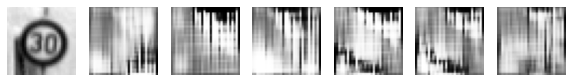

Epoch 271 g_loss= 2.232813 d_loss= 0.35280386 real_acc= 0.88 fake_acc= 0.84
Epoch 272 g_loss= 1.7460105 d_loss= 0.4176426 real_acc= 0.98 fake_acc= 0.54
Epoch 273 g_loss= 2.7336326 d_loss= 0.26438254 real_acc= 0.94 fake_acc= 0.8
Epoch 274 g_loss= 5.118092 d_loss= 0.24068493 real_acc= 0.86 fake_acc= 0.98
Epoch 275 g_loss= 6.4453344 d_loss= 0.54749393 real_acc= 0.76 fake_acc= 1.0
Epoch 276 g_loss= 5.3323765 d_loss= 0.23210606 real_acc= 0.8 fake_acc= 1.0
Epoch 277 g_loss= 3.1300116 d_loss= 0.23026983 real_acc= 0.94 fake_acc= 0.94
Epoch 278 g_loss= 2.1241574 d_loss= 0.21213903 real_acc= 0.98 fake_acc= 0.82
Epoch 279 g_loss= 1.9266952 d_loss= 0.3720668 real_acc= 0.96 fake_acc= 0.72
Epoch 280 g_loss= 2.9746559 d_loss= 0.20483623 real_acc= 0.94 fake_acc= 0.86


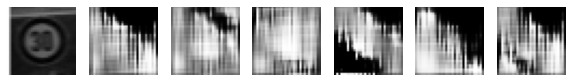

Epoch 281 g_loss= 4.02596 d_loss= 0.22021249 real_acc= 0.82 fake_acc= 0.96
Epoch 282 g_loss= 4.270773 d_loss= 0.111823104 real_acc= 0.96 fake_acc= 1.0
Epoch 283 g_loss= 4.7554426 d_loss= 0.20618102 real_acc= 0.86 fake_acc= 1.0
Epoch 284 g_loss= 4.2585726 d_loss= 0.28081888 real_acc= 0.82 fake_acc= 0.98
Epoch 285 g_loss= 3.8833237 d_loss= 0.121492445 real_acc= 0.98 fake_acc= 0.98
Epoch 286 g_loss= 2.908189 d_loss= 0.19281879 real_acc= 0.94 fake_acc= 0.92
Epoch 287 g_loss= 2.3959486 d_loss= 0.19125077 real_acc= 0.98 fake_acc= 0.88
Epoch 288 g_loss= 3.213174 d_loss= 0.1262132 real_acc= 0.98 fake_acc= 0.96
Epoch 289 g_loss= 3.7180207 d_loss= 0.23820433 real_acc= 0.84 fake_acc= 0.96
Epoch 290 g_loss= 3.8109374 d_loss= 0.14695475 real_acc= 0.92 fake_acc= 1.0


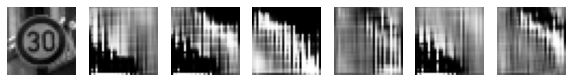

Epoch 291 g_loss= 3.9422894 d_loss= 0.20985344 real_acc= 0.9 fake_acc= 1.0
Epoch 292 g_loss= 3.3985534 d_loss= 0.12215072 real_acc= 0.94 fake_acc= 1.0
Epoch 293 g_loss= 3.1019123 d_loss= 0.23984814 real_acc= 0.9 fake_acc= 0.84
Epoch 294 g_loss= 3.0758014 d_loss= 0.2348369 real_acc= 0.92 fake_acc= 0.84
Epoch 295 g_loss= 2.9730575 d_loss= 0.22456814 real_acc= 0.94 fake_acc= 0.86
Epoch 296 g_loss= 3.52161 d_loss= 0.27961206 real_acc= 0.86 fake_acc= 0.92
Epoch 297 g_loss= 3.2188876 d_loss= 0.2686053 real_acc= 0.84 fake_acc= 0.88
Epoch 298 g_loss= 2.6725433 d_loss= 0.29648596 real_acc= 0.8 fake_acc= 0.92
Epoch 299 g_loss= 2.443547 d_loss= 0.2891447 real_acc= 0.86 fake_acc= 0.78
Epoch 300 g_loss= 2.0281 d_loss= 0.43074524 real_acc= 0.82 fake_acc= 0.74


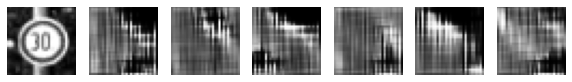

Epoch 301 g_loss= 2.2365992 d_loss= 0.34515682 real_acc= 0.92 fake_acc= 0.72
Epoch 302 g_loss= 2.3202949 d_loss= 0.35056704 real_acc= 0.9 fake_acc= 0.8
Epoch 303 g_loss= 2.6391213 d_loss= 0.42775393 real_acc= 0.74 fake_acc= 0.92
Epoch 304 g_loss= 2.7711933 d_loss= 0.40716612 real_acc= 0.78 fake_acc= 0.84
Epoch 305 g_loss= 2.6115077 d_loss= 0.4238012 real_acc= 0.72 fake_acc= 0.88
Epoch 306 g_loss= 1.7842932 d_loss= 0.4521963 real_acc= 0.88 fake_acc= 0.68
Epoch 307 g_loss= 1.5497458 d_loss= 0.45117527 real_acc= 0.88 fake_acc= 0.66
Epoch 308 g_loss= 1.6025391 d_loss= 0.41328076 real_acc= 0.94 fake_acc= 0.68
Epoch 309 g_loss= 1.7066643 d_loss= 0.39244556 real_acc= 0.92 fake_acc= 0.66
Epoch 310 g_loss= 2.0537598 d_loss= 0.5033951 real_acc= 0.8 fake_acc= 0.76


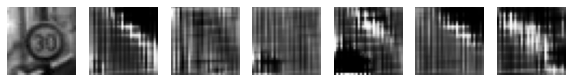

Epoch 311 g_loss= 2.4996798 d_loss= 0.4489166 real_acc= 0.76 fake_acc= 0.84
Epoch 312 g_loss= 2.5072048 d_loss= 0.36790314 real_acc= 0.78 fake_acc= 0.88
Epoch 313 g_loss= 2.770064 d_loss= 0.29812282 real_acc= 0.86 fake_acc= 0.88
Epoch 314 g_loss= 2.5412827 d_loss= 0.34068763 real_acc= 0.92 fake_acc= 0.74
Epoch 315 g_loss= 2.2451162 d_loss= 0.28334624 real_acc= 0.94 fake_acc= 0.76
Epoch 316 g_loss= 2.0880704 d_loss= 0.32918704 real_acc= 0.94 fake_acc= 0.72
Epoch 317 g_loss= 2.0375087 d_loss= 0.38723302 real_acc= 0.92 fake_acc= 0.62
Epoch 318 g_loss= 2.367706 d_loss= 0.34212664 real_acc= 0.92 fake_acc= 0.7
Epoch 319 g_loss= 2.3494353 d_loss= 0.33002418 real_acc= 0.82 fake_acc= 0.84
Epoch 320 g_loss= 3.1587372 d_loss= 0.25251877 real_acc= 0.84 fake_acc= 0.96


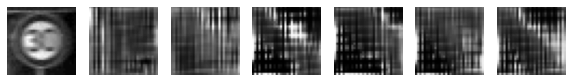

Epoch 321 g_loss= 3.0664902 d_loss= 0.3704589 real_acc= 0.7 fake_acc= 0.98
Epoch 322 g_loss= 2.7744765 d_loss= 0.35450682 real_acc= 0.68 fake_acc= 0.96
Epoch 323 g_loss= 2.004807 d_loss= 0.34183684 real_acc= 0.82 fake_acc= 0.94
Epoch 324 g_loss= 1.3812454 d_loss= 0.40174788 real_acc= 0.88 fake_acc= 0.76
Epoch 325 g_loss= 0.96469164 d_loss= 0.49620062 real_acc= 0.96 fake_acc= 0.46
Epoch 326 g_loss= 1.3561876 d_loss= 0.4185343 real_acc= 0.94 fake_acc= 0.7
Epoch 327 g_loss= 2.3110876 d_loss= 0.4433714 real_acc= 0.68 fake_acc= 0.92
Epoch 328 g_loss= 2.7561932 d_loss= 0.49797451 real_acc= 0.62 fake_acc= 0.94
Epoch 329 g_loss= 3.041431 d_loss= 0.35137674 real_acc= 0.68 fake_acc= 1.0
Epoch 330 g_loss= 2.597976 d_loss= 0.44555122 real_acc= 0.66 fake_acc= 1.0


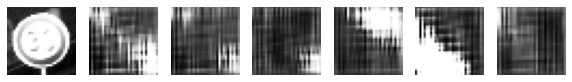

Epoch 331 g_loss= 1.8838726 d_loss= 0.29302755 real_acc= 0.84 fake_acc= 0.96
Epoch 332 g_loss= 1.3025262 d_loss= 0.42506257 real_acc= 0.84 fake_acc= 0.76
Epoch 333 g_loss= 0.9365703 d_loss= 0.47837153 real_acc= 0.92 fake_acc= 0.62
Epoch 334 g_loss= 1.3333646 d_loss= 0.40924504 real_acc= 0.9 fake_acc= 0.68
Epoch 335 g_loss= 1.9599409 d_loss= 0.45237136 real_acc= 0.82 fake_acc= 0.8
Epoch 336 g_loss= 2.5830653 d_loss= 0.48954213 real_acc= 0.64 fake_acc= 0.9
Epoch 337 g_loss= 3.565057 d_loss= 0.36557564 real_acc= 0.68 fake_acc= 1.0
Epoch 338 g_loss= 3.3684874 d_loss= 0.43052036 real_acc= 0.74 fake_acc= 1.0
Epoch 339 g_loss= 2.7954721 d_loss= 0.26236662 real_acc= 0.86 fake_acc= 0.98
Epoch 340 g_loss= 1.8997897 d_loss= 0.23637626 real_acc= 0.9 fake_acc= 0.94


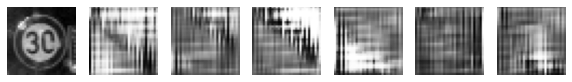

Epoch 341 g_loss= 1.6352148 d_loss= 0.32298517 real_acc= 0.9 fake_acc= 0.78
Epoch 342 g_loss= 1.8037817 d_loss= 0.2744868 real_acc= 0.94 fake_acc= 0.74
Epoch 343 g_loss= 2.2582383 d_loss= 0.16522688 real_acc= 0.94 fake_acc= 0.94
Epoch 344 g_loss= 2.9451318 d_loss= 0.20635393 real_acc= 0.86 fake_acc= 0.98
Epoch 345 g_loss= 3.4456482 d_loss= 0.16252115 real_acc= 0.9 fake_acc= 1.0
Epoch 346 g_loss= 3.8538437 d_loss= 0.30128443 real_acc= 0.72 fake_acc= 1.0
Epoch 347 g_loss= 3.2827957 d_loss= 0.28605318 real_acc= 0.78 fake_acc= 0.96
Epoch 348 g_loss= 3.2366378 d_loss= 0.16524024 real_acc= 0.98 fake_acc= 0.88
Epoch 349 g_loss= 2.6996887 d_loss= 0.28840226 real_acc= 0.88 fake_acc= 0.86
Epoch 350 g_loss= 2.7044864 d_loss= 0.32737654 real_acc= 0.86 fake_acc= 0.8


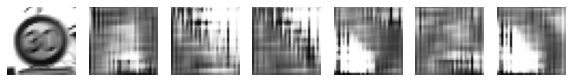

Epoch 351 g_loss= 2.6823466 d_loss= 0.27726305 real_acc= 0.92 fake_acc= 0.78
Epoch 352 g_loss= 2.875962 d_loss= 0.35579216 real_acc= 0.88 fake_acc= 0.8
Epoch 353 g_loss= 3.2014563 d_loss= 0.3555698 real_acc= 0.8 fake_acc= 0.88
Epoch 354 g_loss= 2.9932034 d_loss= 0.3562085 real_acc= 0.78 fake_acc= 0.9
Epoch 355 g_loss= 2.6724658 d_loss= 0.52306867 real_acc= 0.72 fake_acc= 0.7
Epoch 356 g_loss= 2.4781275 d_loss= 0.32150775 real_acc= 0.84 fake_acc= 0.82
Epoch 357 g_loss= 2.2445657 d_loss= 0.36906704 real_acc= 0.98 fake_acc= 0.58
Epoch 358 g_loss= 2.563869 d_loss= 0.354137 real_acc= 0.9 fake_acc= 0.88
Epoch 359 g_loss= 2.9108908 d_loss= 0.4413414 real_acc= 0.72 fake_acc= 0.88
Epoch 360 g_loss= 2.57166 d_loss= 0.4461853 real_acc= 0.78 fake_acc= 0.8


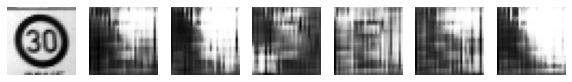

Epoch 361 g_loss= 2.9727542 d_loss= 0.34681496 real_acc= 0.82 fake_acc= 0.8
Epoch 362 g_loss= 2.5296178 d_loss= 0.40700772 real_acc= 0.8 fake_acc= 0.86
Epoch 363 g_loss= 2.0424423 d_loss= 0.534775 real_acc= 0.74 fake_acc= 0.66
Epoch 364 g_loss= 1.587077 d_loss= 0.42324066 real_acc= 0.86 fake_acc= 0.68
Epoch 365 g_loss= 1.5436751 d_loss= 0.4226297 real_acc= 0.8 fake_acc= 0.78
Epoch 366 g_loss= 1.5984828 d_loss= 0.43347642 real_acc= 0.8 fake_acc= 0.76
Epoch 367 g_loss= 1.9724393 d_loss= 0.40357435 real_acc= 0.8 fake_acc= 0.82
Epoch 368 g_loss= 2.4866753 d_loss= 0.5048796 real_acc= 0.7 fake_acc= 0.86
Epoch 369 g_loss= 2.1493292 d_loss= 0.34470502 real_acc= 0.74 fake_acc= 0.94
Epoch 370 g_loss= 1.7334081 d_loss= 0.42401612 real_acc= 0.78 fake_acc= 0.88


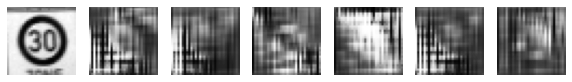

Epoch 371 g_loss= 1.6778095 d_loss= 0.3474658 real_acc= 0.86 fake_acc= 0.9
Epoch 372 g_loss= 1.3236307 d_loss= 0.389472 real_acc= 0.86 fake_acc= 0.78
Epoch 373 g_loss= 1.3275789 d_loss= 0.4244573 real_acc= 0.86 fake_acc= 0.68
Epoch 374 g_loss= 1.5281674 d_loss= 0.45008594 real_acc= 0.72 fake_acc= 0.82
Epoch 375 g_loss= 1.9022962 d_loss= 0.3691002 real_acc= 0.68 fake_acc= 0.96
Epoch 376 g_loss= 2.393158 d_loss= 0.44284397 real_acc= 0.58 fake_acc= 0.98
Epoch 377 g_loss= 1.963465 d_loss= 0.43644893 real_acc= 0.66 fake_acc= 0.92
Epoch 378 g_loss= 1.4973226 d_loss= 0.391182 real_acc= 0.8 fake_acc= 0.9
Epoch 379 g_loss= 1.3630377 d_loss= 0.3529615 real_acc= 0.88 fake_acc= 0.86
Epoch 380 g_loss= 1.1262647 d_loss= 0.41878676 real_acc= 0.9 fake_acc= 0.64


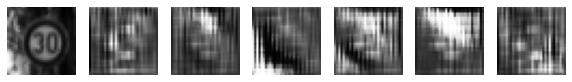

Epoch 381 g_loss= 1.748541 d_loss= 0.5113913 real_acc= 0.62 fake_acc= 0.94
Epoch 382 g_loss= 2.2952852 d_loss= 0.40183353 real_acc= 0.7 fake_acc= 0.98
Epoch 383 g_loss= 2.219673 d_loss= 0.3505553 real_acc= 0.76 fake_acc= 0.94
Epoch 384 g_loss= 1.871788 d_loss= 0.35643172 real_acc= 0.88 fake_acc= 0.84
Epoch 385 g_loss= 1.5652797 d_loss= 0.3610633 real_acc= 0.98 fake_acc= 0.7
Epoch 386 g_loss= 2.0095704 d_loss= 0.26793733 real_acc= 0.92 fake_acc= 0.92
Epoch 387 g_loss= 2.1327028 d_loss= 0.32613614 real_acc= 0.88 fake_acc= 0.88
Epoch 388 g_loss= 3.3311503 d_loss= 0.42459783 real_acc= 0.7 fake_acc= 0.92
Epoch 389 g_loss= 3.5686083 d_loss= 0.3417945 real_acc= 0.72 fake_acc= 0.96
Epoch 390 g_loss= 1.7089161 d_loss= 0.377052 real_acc= 0.9 fake_acc= 0.74


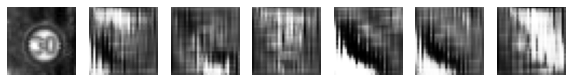

Epoch 391 g_loss= 1.1921443 d_loss= 0.4782213 real_acc= 1.0 fake_acc= 0.4
Epoch 392 g_loss= 1.4583168 d_loss= 0.36560944 real_acc= 1.0 fake_acc= 0.58
Epoch 393 g_loss= 3.146126 d_loss= 0.27888635 real_acc= 0.82 fake_acc= 0.98
Epoch 394 g_loss= 4.079418 d_loss= 0.4450168 real_acc= 0.58 fake_acc= 1.0
Epoch 395 g_loss= 2.969042 d_loss= 0.3422432 real_acc= 0.74 fake_acc= 0.96
Epoch 396 g_loss= 1.815112 d_loss= 0.3125056 real_acc= 0.94 fake_acc= 0.82
Epoch 397 g_loss= 1.1877091 d_loss= 0.39423004 real_acc= 0.96 fake_acc= 0.52
Epoch 398 g_loss= 1.3889865 d_loss= 0.3815423 real_acc= 0.94 fake_acc= 0.62
Epoch 399 g_loss= 2.0337985 d_loss= 0.3029025 real_acc= 0.88 fake_acc= 0.84
Epoch 400 g_loss= 2.4321778 d_loss= 0.31414044 real_acc= 0.78 fake_acc= 0.98


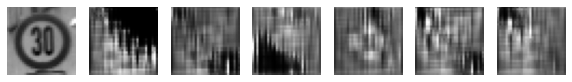

Epoch 401 g_loss= 2.2513542 d_loss= 0.333329 real_acc= 0.84 fake_acc= 0.94
Epoch 402 g_loss= 1.8437696 d_loss= 0.46756622 real_acc= 0.7 fake_acc= 0.96
Epoch 403 g_loss= 1.2576164 d_loss= 0.48510072 real_acc= 0.78 fake_acc= 0.76
Epoch 404 g_loss= 0.86196166 d_loss= 0.5817383 real_acc= 0.88 fake_acc= 0.54
Epoch 405 g_loss= 0.885503 d_loss= 0.57751876 real_acc= 0.8 fake_acc= 0.54
Epoch 406 g_loss= 1.7186183 d_loss= 0.4776578 real_acc= 0.84 fake_acc= 0.72
Epoch 407 g_loss= 1.9959248 d_loss= 0.54556185 real_acc= 0.62 fake_acc= 0.9
Epoch 408 g_loss= 1.632752 d_loss= 0.5083544 real_acc= 0.74 fake_acc= 0.8
Epoch 409 g_loss= 1.1548035 d_loss= 0.5564419 real_acc= 0.8 fake_acc= 0.66
Epoch 410 g_loss= 1.0630246 d_loss= 0.49562907 real_acc= 0.86 fake_acc= 0.68


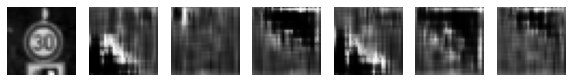

Epoch 411 g_loss= 1.3396683 d_loss= 0.41145107 real_acc= 0.88 fake_acc= 0.74
Epoch 412 g_loss= 1.7805564 d_loss= 0.3570085 real_acc= 0.8 fake_acc= 0.92
Epoch 413 g_loss= 2.2988198 d_loss= 0.30377784 real_acc= 0.74 fake_acc= 1.0
Epoch 414 g_loss= 1.9109343 d_loss= 0.3844248 real_acc= 0.68 fake_acc= 0.92
Epoch 415 g_loss= 1.9313949 d_loss= 0.3520599 real_acc= 0.78 fake_acc= 0.88
Epoch 416 g_loss= 1.5424632 d_loss= 0.31458247 real_acc= 0.9 fake_acc= 0.9
Epoch 417 g_loss= 1.575513 d_loss= 0.35822946 real_acc= 0.86 fake_acc= 0.86
Epoch 418 g_loss= 1.5987705 d_loss= 0.36900628 real_acc= 0.82 fake_acc= 0.82
Epoch 419 g_loss= 1.9399118 d_loss= 0.42080095 real_acc= 0.68 fake_acc= 0.86
Epoch 420 g_loss= 2.111066 d_loss= 0.37364113 real_acc= 0.74 fake_acc= 0.94


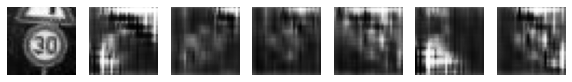

Epoch 421 g_loss= 1.8955258 d_loss= 0.34955734 real_acc= 0.76 fake_acc= 0.88
Epoch 422 g_loss= 1.6959567 d_loss= 0.366408 real_acc= 0.8 fake_acc= 0.88
Epoch 423 g_loss= 1.5328918 d_loss= 0.34914774 real_acc= 0.82 fake_acc= 0.86
Epoch 424 g_loss= 1.7716299 d_loss= 0.34226763 real_acc= 0.8 fake_acc= 0.88
Epoch 425 g_loss= 1.9966234 d_loss= 0.37306058 real_acc= 0.76 fake_acc= 0.88
Epoch 426 g_loss= 1.7090759 d_loss= 0.35359693 real_acc= 0.78 fake_acc= 0.88
Epoch 427 g_loss= 1.6912589 d_loss= 0.46648705 real_acc= 0.6 fake_acc= 0.96
Epoch 428 g_loss= 2.115292 d_loss= 0.31742227 real_acc= 0.84 fake_acc= 0.96
Epoch 429 g_loss= 1.2586125 d_loss= 0.427485 real_acc= 0.82 fake_acc= 0.8
Epoch 430 g_loss= 0.89906645 d_loss= 0.5167494 real_acc= 0.9 fake_acc= 0.58


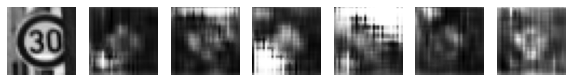

Epoch 431 g_loss= 1.6436548 d_loss= 0.48962486 real_acc= 0.74 fake_acc= 0.82
Epoch 432 g_loss= 2.0785694 d_loss= 0.405934 real_acc= 0.72 fake_acc= 0.94
Epoch 433 g_loss= 1.8153644 d_loss= 0.6176395 real_acc= 0.62 fake_acc= 0.82
Epoch 434 g_loss= 1.1001626 d_loss= 0.4771317 real_acc= 0.84 fake_acc= 0.58
Epoch 435 g_loss= 1.1370033 d_loss= 0.6206037 real_acc= 0.72 fake_acc= 0.62
Epoch 436 g_loss= 1.6515918 d_loss= 0.4799916 real_acc= 0.8 fake_acc= 0.86
Epoch 437 g_loss= 1.8579516 d_loss= 0.56067336 real_acc= 0.54 fake_acc= 0.84
Epoch 438 g_loss= 1.4390206 d_loss= 0.6487627 real_acc= 0.52 fake_acc= 0.82
Epoch 439 g_loss= 0.9742627 d_loss= 0.5862977 real_acc= 0.78 fake_acc= 0.52
Epoch 440 g_loss= 1.2545198 d_loss= 0.4985746 real_acc= 0.7 fake_acc= 0.7


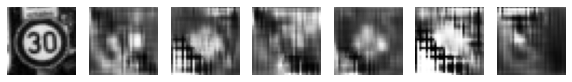

Epoch 441 g_loss= 2.340419 d_loss= 0.41126576 real_acc= 0.7 fake_acc= 0.94
Epoch 442 g_loss= 2.622744 d_loss= 0.51344776 real_acc= 0.66 fake_acc= 0.84
Epoch 443 g_loss= 1.7305719 d_loss= 0.41902995 real_acc= 0.74 fake_acc= 0.84
Epoch 444 g_loss= 1.1695579 d_loss= 0.4954081 real_acc= 0.86 fake_acc= 0.64
Epoch 445 g_loss= 1.2743058 d_loss= 0.4649734 real_acc= 0.82 fake_acc= 0.74
Epoch 446 g_loss= 2.6440477 d_loss= 0.40911746 real_acc= 0.7 fake_acc= 0.86
Epoch 447 g_loss= 3.0015795 d_loss= 0.577979 real_acc= 0.58 fake_acc= 0.88
Epoch 448 g_loss= 1.9355985 d_loss= 0.46441546 real_acc= 0.78 fake_acc= 0.76
Epoch 449 g_loss= 1.5688121 d_loss= 0.5726845 real_acc= 0.8 fake_acc= 0.7
Epoch 450 g_loss= 1.1339297 d_loss= 0.4463126 real_acc= 0.94 fake_acc= 0.64


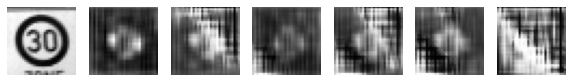

Epoch 451 g_loss= 1.6334378 d_loss= 0.47057006 real_acc= 0.92 fake_acc= 0.6
Epoch 452 g_loss= 2.551991 d_loss= 0.4682976 real_acc= 0.62 fake_acc= 0.96
Epoch 453 g_loss= 2.8167136 d_loss= 0.61459905 real_acc= 0.62 fake_acc= 0.94
Epoch 454 g_loss= 2.2665212 d_loss= 0.48682237 real_acc= 0.64 fake_acc= 0.84
Epoch 455 g_loss= 1.5734794 d_loss= 0.42486745 real_acc= 0.86 fake_acc= 0.72
Epoch 456 g_loss= 1.0193173 d_loss= 0.5286167 real_acc= 0.84 fake_acc= 0.48
Epoch 457 g_loss= 1.3072969 d_loss= 0.5179179 real_acc= 0.8 fake_acc= 0.72
Epoch 458 g_loss= 2.0255096 d_loss= 0.40991822 real_acc= 0.74 fake_acc= 0.94
Epoch 459 g_loss= 2.275508 d_loss= 0.42206877 real_acc= 0.72 fake_acc= 0.94
Epoch 460 g_loss= 2.2114863 d_loss= 0.61489844 real_acc= 0.66 fake_acc= 0.92


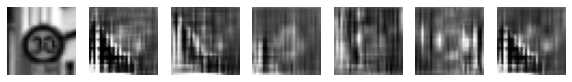

Epoch 461 g_loss= 1.6072315 d_loss= 0.45740747 real_acc= 0.74 fake_acc= 0.82
Epoch 462 g_loss= 1.1493443 d_loss= 0.5503273 real_acc= 0.84 fake_acc= 0.52
Epoch 463 g_loss= 1.1107824 d_loss= 0.39279148 real_acc= 0.92 fake_acc= 0.56
Epoch 464 g_loss= 1.5367954 d_loss= 0.35873592 real_acc= 0.9 fake_acc= 0.82
Epoch 465 g_loss= 2.3091214 d_loss= 0.34249842 real_acc= 0.8 fake_acc= 0.96
Epoch 466 g_loss= 2.673479 d_loss= 0.3079124 real_acc= 0.76 fake_acc= 1.0
Epoch 467 g_loss= 2.7373228 d_loss= 0.3272242 real_acc= 0.8 fake_acc= 0.98
Epoch 468 g_loss= 1.6367526 d_loss= 0.26330304 real_acc= 0.96 fake_acc= 0.92
Epoch 469 g_loss= 1.2534996 d_loss= 0.37858465 real_acc= 0.96 fake_acc= 0.7
Epoch 470 g_loss= 1.5257344 d_loss= 0.26484862 real_acc= 0.94 fake_acc= 0.88


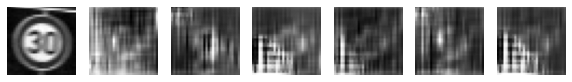

Epoch 471 g_loss= 1.8125569 d_loss= 0.31774238 real_acc= 0.84 fake_acc= 0.96
Epoch 472 g_loss= 2.1961954 d_loss= 0.23912662 real_acc= 0.84 fake_acc= 1.0
Epoch 473 g_loss= 2.3701637 d_loss= 0.25795633 real_acc= 0.86 fake_acc= 1.0
Epoch 474 g_loss= 2.148755 d_loss= 0.28312367 real_acc= 0.82 fake_acc= 0.98
Epoch 475 g_loss= 1.8868676 d_loss= 0.25216392 real_acc= 0.92 fake_acc= 0.9
Epoch 476 g_loss= 1.3667346 d_loss= 0.30227867 real_acc= 0.92 fake_acc= 0.88
Epoch 477 g_loss= 1.5764213 d_loss= 0.34225333 real_acc= 0.86 fake_acc= 0.94
Epoch 478 g_loss= 1.8979907 d_loss= 0.29504627 real_acc= 0.86 fake_acc= 0.96
Epoch 479 g_loss= 1.9609342 d_loss= 0.32870188 real_acc= 0.8 fake_acc= 1.0
Epoch 480 g_loss= 1.9901063 d_loss= 0.28088284 real_acc= 0.88 fake_acc= 1.0


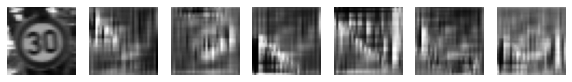

Epoch 481 g_loss= 1.850781 d_loss= 0.268919 real_acc= 0.96 fake_acc= 0.94
Epoch 482 g_loss= 1.8058558 d_loss= 0.21408561 real_acc= 0.96 fake_acc= 0.92
Epoch 483 g_loss= 1.9878545 d_loss= 0.24337795 real_acc= 0.88 fake_acc= 0.94
Epoch 484 g_loss= 2.469555 d_loss= 0.21419084 real_acc= 0.92 fake_acc= 1.0
Epoch 485 g_loss= 2.5829217 d_loss= 0.22550365 real_acc= 0.86 fake_acc= 0.96
Epoch 486 g_loss= 2.7425086 d_loss= 0.22542603 real_acc= 0.86 fake_acc= 1.0
Epoch 487 g_loss= 2.444726 d_loss= 0.19849658 real_acc= 0.92 fake_acc= 0.98
Epoch 488 g_loss= 2.2828965 d_loss= 0.3058462 real_acc= 0.82 fake_acc= 0.9
Epoch 489 g_loss= 1.9302405 d_loss= 0.25432768 real_acc= 1.0 fake_acc= 0.8
Epoch 490 g_loss= 2.387868 d_loss= 0.19497111 real_acc= 0.92 fake_acc= 0.94


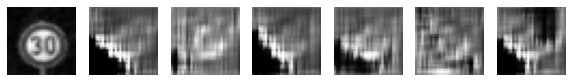

Epoch 491 g_loss= 2.7563348 d_loss= 0.32845277 real_acc= 0.8 fake_acc= 0.98
Epoch 492 g_loss= 3.0727825 d_loss= 0.2876441 real_acc= 0.78 fake_acc= 0.98
Epoch 493 g_loss= 2.5353553 d_loss= 0.20722625 real_acc= 0.94 fake_acc= 0.94
Epoch 494 g_loss= 2.1845233 d_loss= 0.26786333 real_acc= 0.92 fake_acc= 0.84
Epoch 495 g_loss= 2.268177 d_loss= 0.2656643 real_acc= 0.96 fake_acc= 0.82
Epoch 496 g_loss= 2.477407 d_loss= 0.31047106 real_acc= 0.88 fake_acc= 0.86
Epoch 497 g_loss= 3.035735 d_loss= 0.3606231 real_acc= 0.66 fake_acc= 1.0
Epoch 498 g_loss= 2.2764556 d_loss= 0.2784893 real_acc= 0.9 fake_acc= 0.78
Epoch 499 g_loss= 2.3120632 d_loss= 0.29823196 real_acc= 0.86 fake_acc= 0.88
Epoch 500 g_loss= 2.3090801 d_loss= 0.29081288 real_acc= 0.9 fake_acc= 0.82


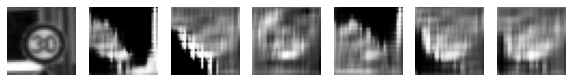

Epoch 501 g_loss= 2.7469606 d_loss= 0.28493682 real_acc= 0.86 fake_acc= 0.92
Epoch 502 g_loss= 2.39599 d_loss= 0.3221413 real_acc= 0.84 fake_acc= 0.92
Epoch 503 g_loss= 2.0232697 d_loss= 0.36518958 real_acc= 0.9 fake_acc= 0.74
Epoch 504 g_loss= 2.1443768 d_loss= 0.35044524 real_acc= 0.88 fake_acc= 0.74
Epoch 505 g_loss= 2.4379323 d_loss= 0.5549959 real_acc= 0.66 fake_acc= 0.86
Epoch 506 g_loss= 1.7553324 d_loss= 0.3964475 real_acc= 0.84 fake_acc= 0.76
Epoch 507 g_loss= 1.7290518 d_loss= 0.39364082 real_acc= 0.94 fake_acc= 0.64
Epoch 508 g_loss= 2.232852 d_loss= 0.3923369 real_acc= 0.76 fake_acc= 0.78
Epoch 509 g_loss= 2.5880902 d_loss= 0.3431992 real_acc= 0.8 fake_acc= 0.98
Epoch 510 g_loss= 2.0959013 d_loss= 0.54653525 real_acc= 0.58 fake_acc= 0.88


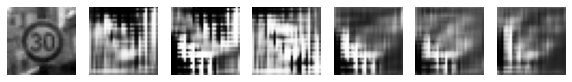

Epoch 511 g_loss= 1.3328083 d_loss= 0.6180817 real_acc= 0.76 fake_acc= 0.6
Epoch 512 g_loss= 0.9508575 d_loss= 0.68272674 real_acc= 0.82 fake_acc= 0.5
Epoch 513 g_loss= 2.149174 d_loss= 0.4523463 real_acc= 0.7 fake_acc= 0.8
Epoch 514 g_loss= 3.2848687 d_loss= 0.7010085 real_acc= 0.54 fake_acc= 0.94
Epoch 515 g_loss= 3.0960145 d_loss= 0.5316537 real_acc= 0.58 fake_acc= 0.88
Epoch 516 g_loss= 2.1858962 d_loss= 0.47955438 real_acc= 0.7 fake_acc= 0.74
Epoch 517 g_loss= 1.6056345 d_loss= 0.55359095 real_acc= 0.9 fake_acc= 0.52
Epoch 518 g_loss= 1.6301925 d_loss= 0.58183515 real_acc= 0.74 fake_acc= 0.72
Epoch 519 g_loss= 3.0609741 d_loss= 0.5307732 real_acc= 0.4 fake_acc= 0.94
Epoch 520 g_loss= 2.7881787 d_loss= 0.42455047 real_acc= 0.72 fake_acc= 0.82


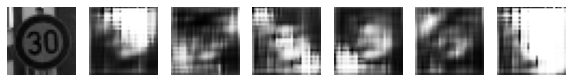

Epoch 521 g_loss= 2.2290788 d_loss= 0.43895194 real_acc= 0.8 fake_acc= 0.82
Epoch 522 g_loss= 1.9912131 d_loss= 0.54257953 real_acc= 0.8 fake_acc= 0.78
Epoch 523 g_loss= 2.199144 d_loss= 0.32969838 real_acc= 0.88 fake_acc= 0.86
Epoch 524 g_loss= 3.1167555 d_loss= 0.32516235 real_acc= 0.82 fake_acc= 0.9
Epoch 525 g_loss= 3.1978106 d_loss= 0.3421415 real_acc= 0.82 fake_acc= 0.86
Epoch 526 g_loss= 3.01341 d_loss= 0.38489467 real_acc= 0.8 fake_acc= 0.88
Epoch 527 g_loss= 2.5183625 d_loss= 0.39124876 real_acc= 0.88 fake_acc= 0.76
Epoch 528 g_loss= 2.6644716 d_loss= 0.4296071 real_acc= 0.94 fake_acc= 0.72
Epoch 529 g_loss= 3.293905 d_loss= 0.44167435 real_acc= 0.82 fake_acc= 0.74
Epoch 530 g_loss= 3.6937745 d_loss= 0.38478306 real_acc= 0.74 fake_acc= 0.9


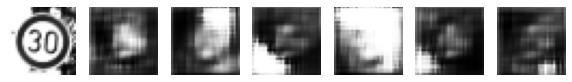

Epoch 531 g_loss= 3.4850276 d_loss= 0.41964272 real_acc= 0.78 fake_acc= 0.84
Epoch 532 g_loss= 2.030324 d_loss= 0.5359636 real_acc= 0.94 fake_acc= 0.56
Epoch 533 g_loss= 2.783963 d_loss= 0.45549476 real_acc= 0.82 fake_acc= 0.74
Epoch 534 g_loss= 3.9471228 d_loss= 0.47656643 real_acc= 0.7 fake_acc= 0.84
Epoch 535 g_loss= 3.8255024 d_loss= 0.42435083 real_acc= 0.66 fake_acc= 0.94
Epoch 536 g_loss= 1.6296955 d_loss= 0.5855063 real_acc= 0.88 fake_acc= 0.68
Epoch 537 g_loss= 1.7040017 d_loss= 0.5146418 real_acc= 0.86 fake_acc= 0.6
Epoch 538 g_loss= 3.0964704 d_loss= 0.6592488 real_acc= 0.64 fake_acc= 0.82
Epoch 539 g_loss= 2.9779532 d_loss= 0.5565703 real_acc= 0.6 fake_acc= 0.84
Epoch 540 g_loss= 1.9958397 d_loss= 0.51087797 real_acc= 0.82 fake_acc= 0.66


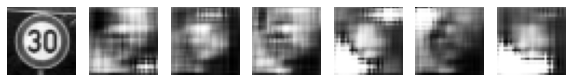

Epoch 541 g_loss= 1.3926396 d_loss= 0.63110894 real_acc= 0.86 fake_acc= 0.56
Epoch 542 g_loss= 2.589192 d_loss= 0.87681305 real_acc= 0.64 fake_acc= 0.68
Epoch 543 g_loss= 3.1448884 d_loss= 0.6306987 real_acc= 0.74 fake_acc= 0.82
Epoch 544 g_loss= 2.5808203 d_loss= 0.36540005 real_acc= 0.88 fake_acc= 0.78
Epoch 545 g_loss= 2.108687 d_loss= 0.4316053 real_acc= 0.92 fake_acc= 0.74
Epoch 546 g_loss= 3.5300336 d_loss= 0.40901852 real_acc= 0.82 fake_acc= 0.82
Epoch 547 g_loss= 3.5365872 d_loss= 0.322192 real_acc= 0.8 fake_acc= 0.9
Epoch 548 g_loss= 3.01302 d_loss= 0.31890166 real_acc= 0.84 fake_acc= 0.82
Epoch 549 g_loss= 3.2534602 d_loss= 0.5474149 real_acc= 0.72 fake_acc= 0.76
Epoch 550 g_loss= 2.3476317 d_loss= 0.37189564 real_acc= 0.92 fake_acc= 0.76


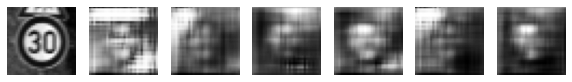

Epoch 551 g_loss= 2.485736 d_loss= 0.36126137 real_acc= 0.9 fake_acc= 0.68
Epoch 552 g_loss= 2.8724127 d_loss= 0.4970618 real_acc= 0.76 fake_acc= 0.76
Epoch 553 g_loss= 3.883706 d_loss= 0.3395543 real_acc= 0.82 fake_acc= 0.88
Epoch 554 g_loss= 3.8979187 d_loss= 0.40867972 real_acc= 0.7 fake_acc= 0.88
Epoch 555 g_loss= 2.7471611 d_loss= 0.34529957 real_acc= 0.94 fake_acc= 0.76
Epoch 556 g_loss= 2.7133956 d_loss= 0.54660416 real_acc= 0.84 fake_acc= 0.7
Epoch 557 g_loss= 2.6620343 d_loss= 0.43258557 real_acc= 0.9 fake_acc= 0.72
Epoch 558 g_loss= 3.2703447 d_loss= 0.33586264 real_acc= 0.86 fake_acc= 0.82
Epoch 559 g_loss= 3.224972 d_loss= 0.35202792 real_acc= 0.82 fake_acc= 0.86
Epoch 560 g_loss= 3.4269006 d_loss= 0.3092147 real_acc= 0.84 fake_acc= 0.8


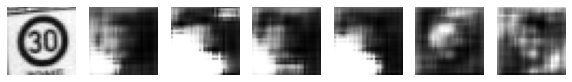

Epoch 561 g_loss= 3.5058084 d_loss= 0.27654323 real_acc= 0.82 fake_acc= 0.9
Epoch 562 g_loss= 3.0592163 d_loss= 0.3541122 real_acc= 0.86 fake_acc= 0.9
Epoch 563 g_loss= 3.5247316 d_loss= 0.22324562 real_acc= 0.92 fake_acc= 0.9
Epoch 564 g_loss= 3.1543984 d_loss= 0.14922883 real_acc= 0.98 fake_acc= 0.98
Epoch 565 g_loss= 3.292657 d_loss= 0.1468224 real_acc= 0.96 fake_acc= 0.98
Epoch 566 g_loss= 3.6082008 d_loss= 0.3056472 real_acc= 0.86 fake_acc= 0.96
Epoch 567 g_loss= 2.8482285 d_loss= 0.29262397 real_acc= 0.82 fake_acc= 1.0
Epoch 568 g_loss= 2.6670763 d_loss= 0.20811015 real_acc= 0.88 fake_acc= 0.98
Epoch 569 g_loss= 2.3235657 d_loss= 0.23252936 real_acc= 0.94 fake_acc= 0.84
Epoch 570 g_loss= 2.4332235 d_loss= 0.18165126 real_acc= 0.96 fake_acc= 0.96


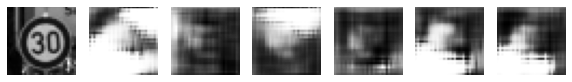

Epoch 571 g_loss= 2.7273164 d_loss= 0.16233093 real_acc= 0.92 fake_acc= 1.0
Epoch 572 g_loss= 3.7005658 d_loss= 0.20827127 real_acc= 0.86 fake_acc= 1.0
Epoch 573 g_loss= 3.4734695 d_loss= 0.17304856 real_acc= 0.94 fake_acc= 1.0
Epoch 574 g_loss= 2.6273706 d_loss= 0.15020959 real_acc= 0.98 fake_acc= 0.94
Epoch 575 g_loss= 2.5747855 d_loss= 0.22933528 real_acc= 0.88 fake_acc= 1.0
Epoch 576 g_loss= 2.0417156 d_loss= 0.25870448 real_acc= 0.92 fake_acc= 0.88
Epoch 577 g_loss= 2.2639582 d_loss= 0.16343021 real_acc= 0.96 fake_acc= 0.96
Epoch 578 g_loss= 2.537301 d_loss= 0.30646402 real_acc= 0.88 fake_acc= 0.92
Epoch 579 g_loss= 2.5296602 d_loss= 0.1874921 real_acc= 0.92 fake_acc= 0.96
Epoch 580 g_loss= 3.1264052 d_loss= 0.15412965 real_acc= 0.94 fake_acc= 0.96


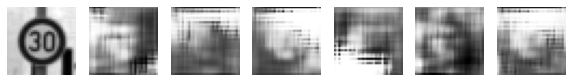

Epoch 581 g_loss= 3.1565075 d_loss= 0.26071838 real_acc= 0.82 fake_acc= 0.94
Epoch 582 g_loss= 2.7460642 d_loss= 0.24843052 real_acc= 0.82 fake_acc= 1.0
Epoch 583 g_loss= 2.3048608 d_loss= 0.15948288 real_acc= 0.96 fake_acc= 0.94
Epoch 584 g_loss= 2.0333169 d_loss= 0.24518564 real_acc= 0.96 fake_acc= 0.88
Epoch 585 g_loss= 2.5128515 d_loss= 0.13036767 real_acc= 1.0 fake_acc= 0.94
Epoch 586 g_loss= 3.3995745 d_loss= 0.19298425 real_acc= 0.92 fake_acc= 0.98
Epoch 587 g_loss= 3.8116825 d_loss= 0.25505504 real_acc= 0.84 fake_acc= 0.98
Epoch 588 g_loss= 3.6589508 d_loss= 0.28363982 real_acc= 0.76 fake_acc= 1.0
Epoch 589 g_loss= 2.1809623 d_loss= 0.21763748 real_acc= 0.9 fake_acc= 0.96
Epoch 590 g_loss= 1.2212875 d_loss= 0.45780984 real_acc= 0.9 fake_acc= 0.6


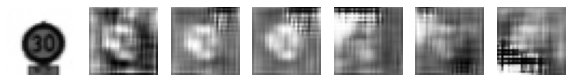

Epoch 591 g_loss= 1.4048761 d_loss= 0.34143957 real_acc= 0.9 fake_acc= 0.78
Epoch 592 g_loss= 2.4378564 d_loss= 0.40983018 real_acc= 0.76 fake_acc= 0.94
Epoch 593 g_loss= 2.7751312 d_loss= 0.38404554 real_acc= 0.78 fake_acc= 0.92
Epoch 594 g_loss= 2.2908926 d_loss= 0.3915367 real_acc= 0.74 fake_acc= 0.9
Epoch 595 g_loss= 1.740816 d_loss= 0.45007682 real_acc= 0.8 fake_acc= 0.8
Epoch 596 g_loss= 1.4209813 d_loss= 0.43622214 real_acc= 0.84 fake_acc= 0.78
Epoch 597 g_loss= 1.3619467 d_loss= 0.4146601 real_acc= 0.9 fake_acc= 0.76
Epoch 598 g_loss= 1.4427849 d_loss= 0.33534324 real_acc= 0.9 fake_acc= 0.82
Epoch 599 g_loss= 1.7999942 d_loss= 0.48762643 real_acc= 0.74 fake_acc= 0.88
Epoch 600 g_loss= 1.9257361 d_loss= 0.34747913 real_acc= 0.86 fake_acc= 0.9


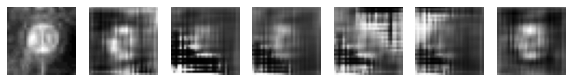

Epoch 601 g_loss= 2.0485904 d_loss= 0.48287565 real_acc= 0.68 fake_acc= 0.92
Epoch 602 g_loss= 1.768981 d_loss= 0.49513397 real_acc= 0.74 fake_acc= 0.88
Epoch 603 g_loss= 1.3315303 d_loss= 0.4215048 real_acc= 0.82 fake_acc= 0.8
Epoch 604 g_loss= 1.0801265 d_loss= 0.4809183 real_acc= 0.84 fake_acc= 0.68
Epoch 605 g_loss= 1.1904116 d_loss= 0.49758086 real_acc= 0.82 fake_acc= 0.74
Epoch 606 g_loss= 1.5371283 d_loss= 0.49884087 real_acc= 0.68 fake_acc= 0.84
Epoch 607 g_loss= 1.5775162 d_loss= 0.43034843 real_acc= 0.68 fake_acc= 0.88
Epoch 608 g_loss= 1.7715777 d_loss= 0.45074457 real_acc= 0.66 fake_acc= 0.94
Epoch 609 g_loss= 2.103548 d_loss= 0.29673192 real_acc= 0.78 fake_acc= 0.9
Epoch 610 g_loss= 1.8075465 d_loss= 0.39433804 real_acc= 0.76 fake_acc= 0.82


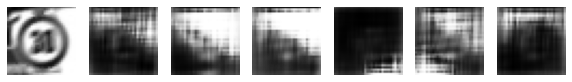

Epoch 611 g_loss= 1.813806 d_loss= 0.42448866 real_acc= 0.76 fake_acc= 0.82
Epoch 612 g_loss= 1.8749576 d_loss= 0.39142725 real_acc= 0.7 fake_acc= 0.88
Epoch 613 g_loss= 2.2460222 d_loss= 0.38596833 real_acc= 0.62 fake_acc= 0.94
Epoch 614 g_loss= 1.7386032 d_loss= 0.3701191 real_acc= 0.9 fake_acc= 0.82
Epoch 615 g_loss= 1.9113253 d_loss= 0.29358667 real_acc= 0.84 fake_acc= 0.88
Epoch 616 g_loss= 2.3161 d_loss= 0.34224218 real_acc= 0.84 fake_acc= 0.88
Epoch 617 g_loss= 2.7083187 d_loss= 0.32484454 real_acc= 0.78 fake_acc= 0.98
Epoch 618 g_loss= 2.2875643 d_loss= 0.27615625 real_acc= 0.84 fake_acc= 0.96
Epoch 619 g_loss= 2.2955942 d_loss= 0.25958192 real_acc= 0.8 fake_acc= 0.96
Epoch 620 g_loss= 2.2505758 d_loss= 0.2317461 real_acc= 0.9 fake_acc= 0.98


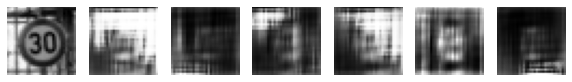

Epoch 621 g_loss= 1.6057749 d_loss= 0.28012645 real_acc= 0.92 fake_acc= 0.88
Epoch 622 g_loss= 1.6597656 d_loss= 0.3437335 real_acc= 0.8 fake_acc= 0.84
Epoch 623 g_loss= 2.051066 d_loss= 0.23634215 real_acc= 0.96 fake_acc= 0.94
Epoch 624 g_loss= 1.7786325 d_loss= 0.3709607 real_acc= 0.76 fake_acc= 0.84
Epoch 625 g_loss= 2.0532715 d_loss= 0.31493455 real_acc= 0.8 fake_acc= 0.94
Epoch 626 g_loss= 1.969939 d_loss= 0.34754518 real_acc= 0.84 fake_acc= 0.88
Epoch 627 g_loss= 1.8727914 d_loss= 0.31073844 real_acc= 0.8 fake_acc= 0.88
Epoch 628 g_loss= 1.7978528 d_loss= 0.39510155 real_acc= 0.8 fake_acc= 0.82
Epoch 629 g_loss= 1.7679759 d_loss= 0.3673752 real_acc= 0.82 fake_acc= 0.84
Epoch 630 g_loss= 1.7954035 d_loss= 0.43647772 real_acc= 0.78 fake_acc= 0.76


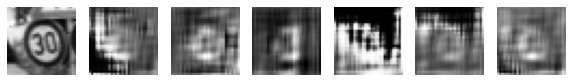

Epoch 631 g_loss= 1.7667156 d_loss= 0.46441555 real_acc= 0.78 fake_acc= 0.72
Epoch 632 g_loss= 2.3059535 d_loss= 0.46451652 real_acc= 0.68 fake_acc= 0.88
Epoch 633 g_loss= 2.2887726 d_loss= 0.45149958 real_acc= 0.76 fake_acc= 0.88
Epoch 634 g_loss= 1.8243628 d_loss= 0.45869267 real_acc= 0.68 fake_acc= 0.78
Epoch 635 g_loss= 1.8910745 d_loss= 0.46248436 real_acc= 0.72 fake_acc= 0.78
Epoch 636 g_loss= 2.0431707 d_loss= 0.3499236 real_acc= 0.86 fake_acc= 0.9
Epoch 637 g_loss= 2.2502275 d_loss= 0.37100592 real_acc= 0.72 fake_acc= 0.92
Epoch 638 g_loss= 2.050286 d_loss= 0.35904324 real_acc= 0.72 fake_acc= 0.98
Epoch 639 g_loss= 1.5302637 d_loss= 0.38328534 real_acc= 0.86 fake_acc= 0.8
Epoch 640 g_loss= 1.7935891 d_loss= 0.30728853 real_acc= 0.9 fake_acc= 0.86


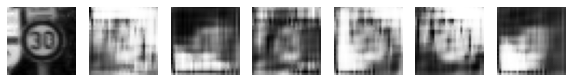

Epoch 641 g_loss= 2.495014 d_loss= 0.26896095 real_acc= 0.86 fake_acc= 0.98
Epoch 642 g_loss= 2.7135115 d_loss= 0.25423187 real_acc= 0.82 fake_acc= 0.98
Epoch 643 g_loss= 2.6828525 d_loss= 0.32531974 real_acc= 0.8 fake_acc= 1.0
Epoch 644 g_loss= 1.9291342 d_loss= 0.31810445 real_acc= 0.86 fake_acc= 0.76
Epoch 645 g_loss= 1.6828216 d_loss= 0.36922365 real_acc= 0.92 fake_acc= 0.68
Epoch 646 g_loss= 2.5334892 d_loss= 0.22224088 real_acc= 0.94 fake_acc= 0.86
Epoch 647 g_loss= 3.3846443 d_loss= 0.45458913 real_acc= 0.68 fake_acc= 0.96
Epoch 648 g_loss= 2.836767 d_loss= 0.3167504 real_acc= 0.82 fake_acc= 0.86
Epoch 649 g_loss= 1.5913672 d_loss= 0.29959345 real_acc= 0.98 fake_acc= 0.76
Epoch 650 g_loss= 1.9119155 d_loss= 0.36295158 real_acc= 0.88 fake_acc= 0.78


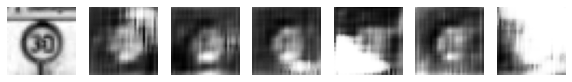

Epoch 651 g_loss= 2.7839057 d_loss= 0.53024924 real_acc= 0.66 fake_acc= 0.96
Epoch 652 g_loss= 2.1640224 d_loss= 0.39887983 real_acc= 0.78 fake_acc= 0.88
Epoch 653 g_loss= 1.7384028 d_loss= 0.38546565 real_acc= 0.82 fake_acc= 0.86
Epoch 654 g_loss= 1.6074815 d_loss= 0.3848908 real_acc= 0.92 fake_acc= 0.74
Epoch 655 g_loss= 2.0171895 d_loss= 0.3883587 real_acc= 0.84 fake_acc= 0.86
Epoch 656 g_loss= 2.6558056 d_loss= 0.3678196 real_acc= 0.76 fake_acc= 0.94
Epoch 657 g_loss= 2.6532342 d_loss= 0.4388758 real_acc= 0.72 fake_acc= 0.92
Epoch 658 g_loss= 2.1703348 d_loss= 0.32408404 real_acc= 0.86 fake_acc= 0.84
Epoch 659 g_loss= 1.9869676 d_loss= 0.390643 real_acc= 0.74 fake_acc= 0.82
Epoch 660 g_loss= 2.1488183 d_loss= 0.31031168 real_acc= 0.8 fake_acc= 0.88


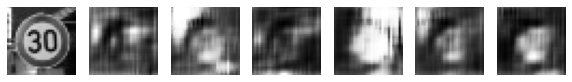

Epoch 661 g_loss= 2.2191274 d_loss= 0.2977854 real_acc= 0.86 fake_acc= 0.9
Epoch 662 g_loss= 2.9306836 d_loss= 0.26760036 real_acc= 0.82 fake_acc= 0.96
Epoch 663 g_loss= 2.8368945 d_loss= 0.25073797 real_acc= 0.84 fake_acc= 0.96
Epoch 664 g_loss= 2.6495256 d_loss= 0.28774184 real_acc= 0.82 fake_acc= 0.9
Epoch 665 g_loss= 2.0715122 d_loss= 0.327855 real_acc= 0.84 fake_acc= 0.82
Epoch 666 g_loss= 2.1921625 d_loss= 0.36110377 real_acc= 0.9 fake_acc= 0.82
Epoch 667 g_loss= 2.8376126 d_loss= 0.20765215 real_acc= 0.86 fake_acc= 0.98
Epoch 668 g_loss= 3.0077631 d_loss= 0.280886 real_acc= 0.82 fake_acc= 0.94
Epoch 669 g_loss= 3.0219893 d_loss= 0.35319835 real_acc= 0.86 fake_acc= 0.84
Epoch 670 g_loss= 2.8276422 d_loss= 0.2810743 real_acc= 0.9 fake_acc= 0.82


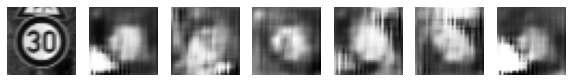

Epoch 671 g_loss= 3.5124488 d_loss= 0.20176452 real_acc= 0.92 fake_acc= 0.94
Epoch 672 g_loss= 3.818612 d_loss= 0.31466916 real_acc= 0.84 fake_acc= 0.96
Epoch 673 g_loss= 3.4547613 d_loss= 0.2700559 real_acc= 0.8 fake_acc= 0.96
Epoch 674 g_loss= 2.8920753 d_loss= 0.32729566 real_acc= 0.86 fake_acc= 0.78
Epoch 675 g_loss= 3.569322 d_loss= 0.2847488 real_acc= 0.86 fake_acc= 0.9
Epoch 676 g_loss= 3.1205542 d_loss= 0.397532 real_acc= 0.82 fake_acc= 0.92
Epoch 677 g_loss= 2.5978243 d_loss= 0.288898 real_acc= 0.9 fake_acc= 0.84
Epoch 678 g_loss= 2.6525083 d_loss= 0.39653975 real_acc= 0.86 fake_acc= 0.78
Epoch 679 g_loss= 2.243416 d_loss= 0.36305997 real_acc= 0.96 fake_acc= 0.68
Epoch 680 g_loss= 3.9161658 d_loss= 0.39106885 real_acc= 0.68 fake_acc= 0.94


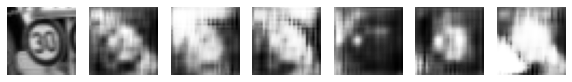

Epoch 681 g_loss= 3.5374417 d_loss= 0.7228356 real_acc= 0.58 fake_acc= 0.92
Epoch 682 g_loss= 2.0803788 d_loss= 0.48801363 real_acc= 0.86 fake_acc= 0.78
Epoch 683 g_loss= 1.0748882 d_loss= 0.62900454 real_acc= 0.92 fake_acc= 0.46
Epoch 684 g_loss= 1.8820508 d_loss= 0.45309934 real_acc= 0.84 fake_acc= 0.76
Epoch 685 g_loss= 3.4297574 d_loss= 0.7239 real_acc= 0.56 fake_acc= 0.98
Epoch 686 g_loss= 3.3914838 d_loss= 0.6013711 real_acc= 0.6 fake_acc= 0.92
Epoch 687 g_loss= 1.6863672 d_loss= 0.44170633 real_acc= 0.86 fake_acc= 0.7
Epoch 688 g_loss= 1.1376104 d_loss= 0.5960683 real_acc= 0.92 fake_acc= 0.44
Epoch 689 g_loss= 2.0860138 d_loss= 0.49466905 real_acc= 0.8 fake_acc= 0.76
Epoch 690 g_loss= 3.273015 d_loss= 0.48561034 real_acc= 0.7 fake_acc= 0.96


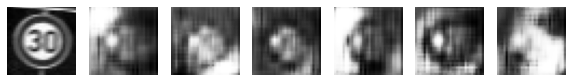

Epoch 691 g_loss= 3.1140246 d_loss= 0.46259773 real_acc= 0.7 fake_acc= 0.96
Epoch 692 g_loss= 2.6372647 d_loss= 0.5038233 real_acc= 0.7 fake_acc= 0.84
Epoch 693 g_loss= 1.6429775 d_loss= 0.49369562 real_acc= 0.84 fake_acc= 0.7
Epoch 694 g_loss= 1.3315723 d_loss= 0.71643853 real_acc= 0.8 fake_acc= 0.56
Epoch 695 g_loss= 1.6172137 d_loss= 0.4198244 real_acc= 0.82 fake_acc= 0.8
Epoch 696 g_loss= 2.5234234 d_loss= 0.38310874 real_acc= 0.76 fake_acc= 0.92
Epoch 697 g_loss= 3.0233903 d_loss= 0.3209992 real_acc= 0.74 fake_acc= 0.98
Epoch 698 g_loss= 3.0257921 d_loss= 0.44826296 real_acc= 0.62 fake_acc= 0.92
Epoch 699 g_loss= 2.5754118 d_loss= 0.34628466 real_acc= 0.86 fake_acc= 0.92
Epoch 700 g_loss= 2.1775806 d_loss= 0.33067974 real_acc= 0.9 fake_acc= 0.86


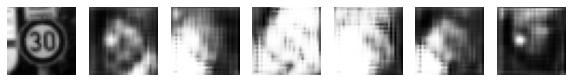

Epoch 701 g_loss= 1.6588024 d_loss= 0.39412776 real_acc= 0.86 fake_acc= 0.8
Epoch 702 g_loss= 1.8370004 d_loss= 0.3884233 real_acc= 0.86 fake_acc= 0.8
Epoch 703 g_loss= 2.3231535 d_loss= 0.32259345 real_acc= 0.84 fake_acc= 0.9
Epoch 704 g_loss= 3.2536163 d_loss= 0.52832836 real_acc= 0.64 fake_acc= 1.0
Epoch 705 g_loss= 2.394877 d_loss= 0.4272859 real_acc= 0.76 fake_acc= 0.86
Epoch 706 g_loss= 2.2388706 d_loss= 0.29246038 real_acc= 0.9 fake_acc= 0.84
Epoch 707 g_loss= 2.0661712 d_loss= 0.31244975 real_acc= 0.88 fake_acc= 0.9
Epoch 708 g_loss= 1.873353 d_loss= 0.2551202 real_acc= 0.92 fake_acc= 0.92
Epoch 709 g_loss= 2.2456434 d_loss= 0.33380094 real_acc= 0.84 fake_acc= 0.92
Epoch 710 g_loss= 2.195453 d_loss= 0.26314625 real_acc= 0.92 fake_acc= 0.9


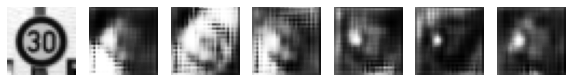

Epoch 711 g_loss= 2.8727198 d_loss= 0.28103632 real_acc= 0.8 fake_acc= 0.98
Epoch 712 g_loss= 2.8186464 d_loss= 0.35812363 real_acc= 0.78 fake_acc= 0.98
Epoch 713 g_loss= 2.289358 d_loss= 0.36041668 real_acc= 0.9 fake_acc= 0.88
Epoch 714 g_loss= 1.4776216 d_loss= 0.3375422 real_acc= 0.92 fake_acc= 0.7
Epoch 715 g_loss= 1.7619696 d_loss= 0.38626033 real_acc= 0.88 fake_acc= 0.78
Epoch 716 g_loss= 2.633729 d_loss= 0.3171967 real_acc= 0.84 fake_acc= 0.98
Epoch 717 g_loss= 2.814928 d_loss= 0.26829278 real_acc= 0.86 fake_acc= 0.92
Epoch 718 g_loss= 2.6507642 d_loss= 0.19295529 real_acc= 0.94 fake_acc= 0.94
Epoch 719 g_loss= 2.8257644 d_loss= 0.19479674 real_acc= 0.92 fake_acc= 1.0
Epoch 720 g_loss= 3.069494 d_loss= 0.16723055 real_acc= 0.9 fake_acc= 0.96


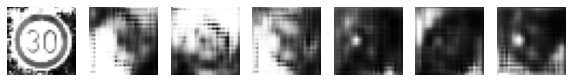

Epoch 721 g_loss= 2.5415852 d_loss= 0.25927913 real_acc= 0.9 fake_acc= 0.9
Epoch 722 g_loss= 2.585608 d_loss= 0.19762075 real_acc= 0.94 fake_acc= 0.92
Epoch 723 g_loss= 2.4564126 d_loss= 0.25169808 real_acc= 0.92 fake_acc= 0.96
Epoch 724 g_loss= 2.850758 d_loss= 0.18927923 real_acc= 0.94 fake_acc= 0.96
Epoch 725 g_loss= 2.8855 d_loss= 0.20923072 real_acc= 0.9 fake_acc= 0.94
Epoch 726 g_loss= 2.966352 d_loss= 0.2543373 real_acc= 0.88 fake_acc= 0.98
Epoch 727 g_loss= 2.9792957 d_loss= 0.21797296 real_acc= 0.9 fake_acc= 0.94
Epoch 728 g_loss= 2.4615476 d_loss= 0.2590382 real_acc= 0.94 fake_acc= 0.92
Epoch 729 g_loss= 2.3167298 d_loss= 0.2851895 real_acc= 0.9 fake_acc= 0.92
Epoch 730 g_loss= 3.0898874 d_loss= 0.41107124 real_acc= 0.82 fake_acc= 0.96


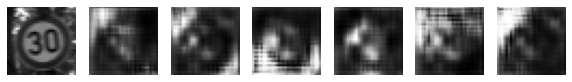

Epoch 731 g_loss= 2.105391 d_loss= 0.22115734 real_acc= 1.0 fake_acc= 0.86
Epoch 732 g_loss= 1.9325153 d_loss= 0.2523105 real_acc= 0.98 fake_acc= 0.86
Epoch 733 g_loss= 2.4922094 d_loss= 0.27535117 real_acc= 0.92 fake_acc= 0.92
Epoch 734 g_loss= 2.8707426 d_loss= 0.38889533 real_acc= 0.74 fake_acc= 1.0
Epoch 735 g_loss= 2.2242749 d_loss= 0.41933838 real_acc= 0.8 fake_acc= 0.8
Epoch 736 g_loss= 1.3013731 d_loss= 0.40513468 real_acc= 0.96 fake_acc= 0.64
Epoch 737 g_loss= 1.2550853 d_loss= 0.48149619 real_acc= 0.88 fake_acc= 0.66
Epoch 738 g_loss= 2.525869 d_loss= 0.42385608 real_acc= 0.72 fake_acc= 0.94
Epoch 739 g_loss= 2.4763126 d_loss= 0.42175582 real_acc= 0.7 fake_acc= 0.96
Epoch 740 g_loss= 1.6323211 d_loss= 0.5222395 real_acc= 0.7 fake_acc= 0.88


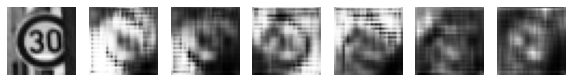

Epoch 741 g_loss= 1.2120098 d_loss= 0.4569784 real_acc= 0.88 fake_acc= 0.72
Epoch 742 g_loss= 1.0265503 d_loss= 0.507306 real_acc= 0.9 fake_acc= 0.58
Epoch 743 g_loss= 1.5255007 d_loss= 0.41747707 real_acc= 0.84 fake_acc= 0.78
Epoch 744 g_loss= 2.5379384 d_loss= 0.7494189 real_acc= 0.46 fake_acc= 1.0
Epoch 745 g_loss= 2.3148193 d_loss= 0.5687462 real_acc= 0.58 fake_acc= 0.98
Epoch 746 g_loss= 0.89775556 d_loss= 0.6773235 real_acc= 0.78 fake_acc= 0.46
Epoch 747 g_loss= 0.68640244 d_loss= 0.61961734 real_acc= 0.94 fake_acc= 0.42
Epoch 748 g_loss= 0.9543947 d_loss= 0.5953447 real_acc= 0.82 fake_acc= 0.58
Epoch 749 g_loss= 1.9459692 d_loss= 0.45943806 real_acc= 0.6 fake_acc= 0.94
Epoch 750 g_loss= 2.5666645 d_loss= 0.5849871 real_acc= 0.48 fake_acc= 1.0


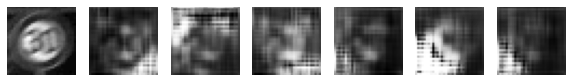

Epoch 751 g_loss= 1.8665972 d_loss= 0.36189762 real_acc= 0.78 fake_acc= 0.94
Epoch 752 g_loss= 1.4169366 d_loss= 0.3118677 real_acc= 0.88 fake_acc= 0.74
Epoch 753 g_loss= 1.1512965 d_loss= 0.4041525 real_acc= 0.88 fake_acc= 0.72
Epoch 754 g_loss= 1.6578788 d_loss= 0.3092383 real_acc= 0.82 fake_acc= 0.94
Epoch 755 g_loss= 1.7479182 d_loss= 0.35482848 real_acc= 0.84 fake_acc= 0.92
Epoch 756 g_loss= 2.1456785 d_loss= 0.3067663 real_acc= 0.8 fake_acc= 0.98
Epoch 757 g_loss= 2.1874993 d_loss= 0.2824974 real_acc= 0.86 fake_acc= 0.98
Epoch 758 g_loss= 2.111281 d_loss= 0.3883912 real_acc= 0.82 fake_acc= 0.94
Epoch 759 g_loss= 1.7619382 d_loss= 0.27337393 real_acc= 0.94 fake_acc= 0.88
Epoch 760 g_loss= 2.2418828 d_loss= 0.38485706 real_acc= 0.76 fake_acc= 0.92


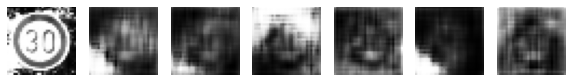

Epoch 761 g_loss= 1.7425733 d_loss= 0.39996773 real_acc= 0.84 fake_acc= 0.78
Epoch 762 g_loss= 2.1689866 d_loss= 0.31764886 real_acc= 0.88 fake_acc= 0.86
Epoch 763 g_loss= 2.088723 d_loss= 0.4177487 real_acc= 0.74 fake_acc= 0.8
Epoch 764 g_loss= 2.1304762 d_loss= 0.33425772 real_acc= 0.82 fake_acc= 0.9
Epoch 765 g_loss= 2.360501 d_loss= 0.35133886 real_acc= 0.84 fake_acc= 0.88
Epoch 766 g_loss= 2.2697875 d_loss= 0.34959337 real_acc= 0.74 fake_acc= 0.92
Epoch 767 g_loss= 1.766127 d_loss= 0.3176825 real_acc= 0.82 fake_acc= 0.9
Epoch 768 g_loss= 1.3716481 d_loss= 0.34346873 real_acc= 0.92 fake_acc= 0.78
Epoch 769 g_loss= 1.8514992 d_loss= 0.2580602 real_acc= 0.94 fake_acc= 0.9
Epoch 770 g_loss= 2.2114522 d_loss= 0.23796919 real_acc= 0.92 fake_acc= 0.94


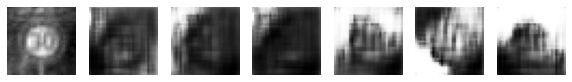

Epoch 771 g_loss= 2.4767258 d_loss= 0.29772216 real_acc= 0.78 fake_acc= 0.96
Epoch 772 g_loss= 3.0661323 d_loss= 0.33170184 real_acc= 0.72 fake_acc= 0.98
Epoch 773 g_loss= 2.5116313 d_loss= 0.44958037 real_acc= 0.68 fake_acc= 0.92
Epoch 774 g_loss= 2.293431 d_loss= 0.4497471 real_acc= 0.72 fake_acc= 0.9
Epoch 775 g_loss= 1.68258 d_loss= 0.47639522 real_acc= 0.9 fake_acc= 0.76
Epoch 776 g_loss= 1.6889743 d_loss= 0.42335856 real_acc= 0.86 fake_acc= 0.72
Epoch 777 g_loss= 1.9335779 d_loss= 0.5161518 real_acc= 0.78 fake_acc= 0.8
Epoch 778 g_loss= 2.215904 d_loss= 0.3824155 real_acc= 0.72 fake_acc= 0.92
Epoch 779 g_loss= 3.1376982 d_loss= 0.56116384 real_acc= 0.58 fake_acc= 0.9
Epoch 780 g_loss= 2.4742234 d_loss= 0.47304666 real_acc= 0.66 fake_acc= 0.88


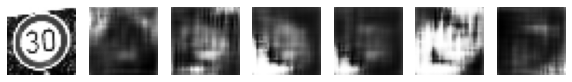

Epoch 781 g_loss= 1.8573959 d_loss= 0.39858747 real_acc= 0.82 fake_acc= 0.82
Epoch 782 g_loss= 1.4243042 d_loss= 0.4058709 real_acc= 0.96 fake_acc= 0.68
Epoch 783 g_loss= 1.6133919 d_loss= 0.3508827 real_acc= 0.9 fake_acc= 0.84
Epoch 784 g_loss= 2.0272555 d_loss= 0.38539118 real_acc= 0.76 fake_acc= 0.9
Epoch 785 g_loss= 2.3310227 d_loss= 0.40560952 real_acc= 0.72 fake_acc= 0.9
Epoch 786 g_loss= 3.0571058 d_loss= 0.24277529 real_acc= 0.78 fake_acc= 0.98
Epoch 787 g_loss= 2.6586027 d_loss= 0.32112497 real_acc= 0.76 fake_acc= 0.98
Epoch 788 g_loss= 2.1900146 d_loss= 0.28238803 real_acc= 0.84 fake_acc= 0.94
Epoch 789 g_loss= 1.7604952 d_loss= 0.33017117 real_acc= 0.88 fake_acc= 0.88
Epoch 790 g_loss= 1.8809448 d_loss= 0.3343196 real_acc= 0.84 fake_acc= 0.88


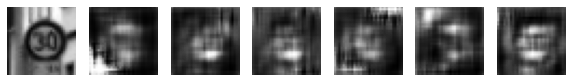

Epoch 791 g_loss= 1.5076758 d_loss= 0.37349212 real_acc= 0.86 fake_acc= 0.8
Epoch 792 g_loss= 1.7643465 d_loss= 0.30427086 real_acc= 0.88 fake_acc= 0.84
Epoch 793 g_loss= 2.1369088 d_loss= 0.36794004 real_acc= 0.72 fake_acc= 0.96
Epoch 794 g_loss= 2.3518004 d_loss= 0.44660264 real_acc= 0.7 fake_acc= 0.96
Epoch 795 g_loss= 2.3049014 d_loss= 0.37578818 real_acc= 0.78 fake_acc= 0.94
Epoch 796 g_loss= 2.013315 d_loss= 0.48540038 real_acc= 0.58 fake_acc= 0.86
Epoch 797 g_loss= 1.5826654 d_loss= 0.46766925 real_acc= 0.74 fake_acc= 0.82
Epoch 798 g_loss= 1.2883762 d_loss= 0.52933466 real_acc= 0.8 fake_acc= 0.74
Epoch 799 g_loss= 1.7761829 d_loss= 0.47855568 real_acc= 0.72 fake_acc= 0.78
Epoch 800 g_loss= 1.4523271 d_loss= 0.5230899 real_acc= 0.78 fake_acc= 0.78


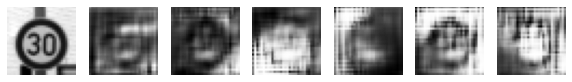

Epoch 801 g_loss= 1.5455555 d_loss= 0.5010427 real_acc= 0.78 fake_acc= 0.8
Epoch 802 g_loss= 1.7192994 d_loss= 0.50797975 real_acc= 0.68 fake_acc= 0.92
Epoch 803 g_loss= 1.5345871 d_loss= 0.5655185 real_acc= 0.6 fake_acc= 0.84
Epoch 804 g_loss= 1.561427 d_loss= 0.544728 real_acc= 0.68 fake_acc= 0.8
Epoch 805 g_loss= 1.4664621 d_loss= 0.6674652 real_acc= 0.64 fake_acc= 0.86
Epoch 806 g_loss= 1.4805564 d_loss= 0.46470535 real_acc= 0.8 fake_acc= 0.8
Epoch 807 g_loss= 1.4035788 d_loss= 0.6296543 real_acc= 0.72 fake_acc= 0.72
Epoch 808 g_loss= 1.6265111 d_loss= 0.560192 real_acc= 0.76 fake_acc= 0.8
Epoch 809 g_loss= 1.7681972 d_loss= 0.6355921 real_acc= 0.74 fake_acc= 0.8
Epoch 810 g_loss= 2.0640619 d_loss= 0.51249886 real_acc= 0.74 fake_acc= 0.82


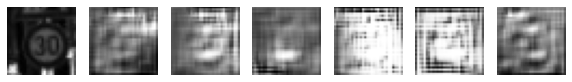

Epoch 811 g_loss= 1.9925021 d_loss= 0.45562303 real_acc= 0.7 fake_acc= 0.82
Epoch 812 g_loss= 1.839606 d_loss= 0.38927072 real_acc= 0.88 fake_acc= 0.88
Epoch 813 g_loss= 1.7237238 d_loss= 0.38088638 real_acc= 0.82 fake_acc= 0.88
Epoch 814 g_loss= 1.6353393 d_loss= 0.4237646 real_acc= 0.86 fake_acc= 0.84
Epoch 815 g_loss= 1.7791525 d_loss= 0.3088501 real_acc= 0.88 fake_acc= 0.88
Epoch 816 g_loss= 2.0821702 d_loss= 0.42445573 real_acc= 0.82 fake_acc= 0.86
Epoch 817 g_loss= 2.252183 d_loss= 0.4101286 real_acc= 0.8 fake_acc= 0.92
Epoch 818 g_loss= 2.0721781 d_loss= 0.37739012 real_acc= 0.84 fake_acc= 0.84
Epoch 819 g_loss= 1.7248263 d_loss= 0.52031076 real_acc= 0.82 fake_acc= 0.68
Epoch 820 g_loss= 1.5930552 d_loss= 0.5111906 real_acc= 0.82 fake_acc= 0.72


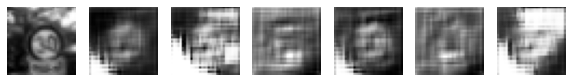

Epoch 821 g_loss= 1.9084896 d_loss= 0.47566855 real_acc= 0.74 fake_acc= 0.72
Epoch 822 g_loss= 1.7261728 d_loss= 0.36019573 real_acc= 0.92 fake_acc= 0.76
Epoch 823 g_loss= 1.7923776 d_loss= 0.47029096 real_acc= 0.82 fake_acc= 0.76
Epoch 824 g_loss= 1.8495156 d_loss= 0.49430025 real_acc= 0.78 fake_acc= 0.74
Epoch 825 g_loss= 2.0119123 d_loss= 0.48502344 real_acc= 0.82 fake_acc= 0.86
Epoch 826 g_loss= 1.8820655 d_loss= 0.58521867 real_acc= 0.74 fake_acc= 0.8
Epoch 827 g_loss= 1.2392385 d_loss= 0.542895 real_acc= 0.76 fake_acc= 0.72
Epoch 828 g_loss= 1.3641825 d_loss= 0.5074693 real_acc= 0.82 fake_acc= 0.7
Epoch 829 g_loss= 1.6890378 d_loss= 0.38570938 real_acc= 0.82 fake_acc= 0.88
Epoch 830 g_loss= 2.5981476 d_loss= 0.37594888 real_acc= 0.8 fake_acc= 0.92


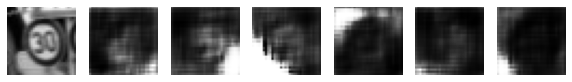

Epoch 831 g_loss= 2.3114007 d_loss= 0.3677365 real_acc= 0.72 fake_acc= 0.96
Epoch 832 g_loss= 2.5022802 d_loss= 0.3554715 real_acc= 0.68 fake_acc= 0.96
Epoch 833 g_loss= 2.6763394 d_loss= 0.38609982 real_acc= 0.74 fake_acc= 0.9
Epoch 834 g_loss= 2.4689407 d_loss= 0.36460865 real_acc= 0.78 fake_acc= 0.88
Epoch 835 g_loss= 2.0756934 d_loss= 0.35788867 real_acc= 0.8 fake_acc= 0.84
Epoch 836 g_loss= 2.5368154 d_loss= 0.2762314 real_acc= 0.88 fake_acc= 0.82
Epoch 837 g_loss= 2.821242 d_loss= 0.24687976 real_acc= 0.88 fake_acc= 0.94
Epoch 838 g_loss= 3.328637 d_loss= 0.3559604 real_acc= 0.62 fake_acc= 0.98
Epoch 839 g_loss= 2.820863 d_loss= 0.33415082 real_acc= 0.8 fake_acc= 0.94
Epoch 840 g_loss= 2.3498936 d_loss= 0.3987379 real_acc= 0.8 fake_acc= 0.82


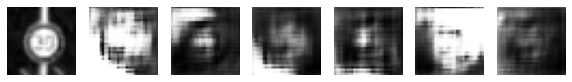

Epoch 841 g_loss= 1.7815504 d_loss= 0.4301954 real_acc= 0.9 fake_acc= 0.74
Epoch 842 g_loss= 2.251857 d_loss= 0.41212606 real_acc= 0.82 fake_acc= 0.82
Epoch 843 g_loss= 3.0481176 d_loss= 0.36925516 real_acc= 0.68 fake_acc= 0.94
Epoch 844 g_loss= 2.7772377 d_loss= 0.47842377 real_acc= 0.66 fake_acc= 0.88
Epoch 845 g_loss= 1.9661996 d_loss= 0.4557682 real_acc= 0.86 fake_acc= 0.8
Epoch 846 g_loss= 1.5513558 d_loss= 0.70861256 real_acc= 0.78 fake_acc= 0.7
Epoch 847 g_loss= 1.9376758 d_loss= 0.4180276 real_acc= 0.8 fake_acc= 0.8
Epoch 848 g_loss= 2.8342957 d_loss= 0.6539929 real_acc= 0.5 fake_acc= 0.86
Epoch 849 g_loss= 1.6920745 d_loss= 0.57854116 real_acc= 0.74 fake_acc= 0.82
Epoch 850 g_loss= 1.389423 d_loss= 0.64962476 real_acc= 0.7 fake_acc= 0.72


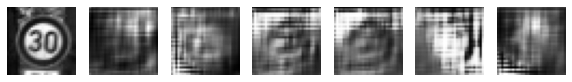

Epoch 851 g_loss= 1.5563854 d_loss= 0.49294207 real_acc= 0.9 fake_acc= 0.66
Epoch 852 g_loss= 2.082078 d_loss= 0.7140722 real_acc= 0.56 fake_acc= 0.8
Epoch 853 g_loss= 2.7662158 d_loss= 0.5433724 real_acc= 0.64 fake_acc= 0.94
Epoch 854 g_loss= 2.5068426 d_loss= 0.40978724 real_acc= 0.72 fake_acc= 0.94
Epoch 855 g_loss= 2.1259012 d_loss= 0.3909695 real_acc= 0.86 fake_acc= 0.82
Epoch 856 g_loss= 1.6908838 d_loss= 0.39403373 real_acc= 0.86 fake_acc= 0.78
Epoch 857 g_loss= 1.4330019 d_loss= 0.38696045 real_acc= 0.94 fake_acc= 0.62
Epoch 858 g_loss= 1.938717 d_loss= 0.34315 real_acc= 0.9 fake_acc= 0.7
Epoch 859 g_loss= 2.314347 d_loss= 0.4017627 real_acc= 0.78 fake_acc= 0.82
Epoch 860 g_loss= 3.0592706 d_loss= 0.4359187 real_acc= 0.74 fake_acc= 0.9


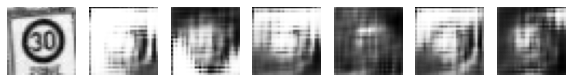

Epoch 861 g_loss= 2.5628345 d_loss= 0.44689858 real_acc= 0.7 fake_acc= 0.82
Epoch 862 g_loss= 2.1961956 d_loss= 0.47379577 real_acc= 0.84 fake_acc= 0.72
Epoch 863 g_loss= 2.107736 d_loss= 0.3864429 real_acc= 0.88 fake_acc= 0.74
Epoch 864 g_loss= 2.352988 d_loss= 0.31867272 real_acc= 0.86 fake_acc= 0.8
Epoch 865 g_loss= 2.5859594 d_loss= 0.36903733 real_acc= 0.76 fake_acc= 0.92
Epoch 866 g_loss= 3.0736709 d_loss= 0.37803128 real_acc= 0.64 fake_acc= 1.0
Epoch 867 g_loss= 2.6568153 d_loss= 0.4290443 real_acc= 0.72 fake_acc= 0.92
Epoch 868 g_loss= 1.7774891 d_loss= 0.30012834 real_acc= 0.84 fake_acc= 0.94
Epoch 869 g_loss= 1.5598907 d_loss= 0.37285912 real_acc= 0.82 fake_acc= 0.78
Epoch 870 g_loss= 1.9076104 d_loss= 0.32986367 real_acc= 0.88 fake_acc= 0.88


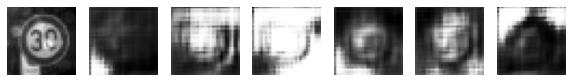

Epoch 871 g_loss= 2.590274 d_loss= 0.31552738 real_acc= 0.76 fake_acc= 1.0
Epoch 872 g_loss= 2.9710095 d_loss= 0.39855602 real_acc= 0.68 fake_acc= 1.0
Epoch 873 g_loss= 2.9003155 d_loss= 0.3747378 real_acc= 0.62 fake_acc= 1.0
Epoch 874 g_loss= 1.8808372 d_loss= 0.3417406 real_acc= 0.86 fake_acc= 0.86
Epoch 875 g_loss= 1.4044533 d_loss= 0.32619333 real_acc= 0.96 fake_acc= 0.78
Epoch 876 g_loss= 1.8175491 d_loss= 0.29125792 real_acc= 0.86 fake_acc= 0.82
Epoch 877 g_loss= 2.6430228 d_loss= 0.3724783 real_acc= 0.78 fake_acc= 0.96
Epoch 878 g_loss= 2.7098382 d_loss= 0.29459655 real_acc= 0.76 fake_acc= 0.98
Epoch 879 g_loss= 2.826064 d_loss= 0.36737844 real_acc= 0.76 fake_acc= 0.98
Epoch 880 g_loss= 2.1939347 d_loss= 0.3502369 real_acc= 0.84 fake_acc= 0.86


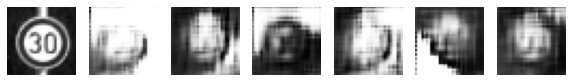

Epoch 881 g_loss= 1.6527148 d_loss= 0.36689278 real_acc= 0.86 fake_acc= 0.76
Epoch 882 g_loss= 1.9367764 d_loss= 0.27777958 real_acc= 0.94 fake_acc= 0.88
Epoch 883 g_loss= 2.3538952 d_loss= 0.33752042 real_acc= 0.76 fake_acc= 0.92
Epoch 884 g_loss= 3.07645 d_loss= 0.3218038 real_acc= 0.82 fake_acc= 1.0
Epoch 885 g_loss= 2.300791 d_loss= 0.18682277 real_acc= 0.98 fake_acc= 0.94
Epoch 886 g_loss= 2.130463 d_loss= 0.33115354 real_acc= 0.8 fake_acc= 0.98
Epoch 887 g_loss= 1.939354 d_loss= 0.32127985 real_acc= 0.92 fake_acc= 0.82
Epoch 888 g_loss= 2.2916176 d_loss= 0.24251789 real_acc= 0.92 fake_acc= 1.0
Epoch 889 g_loss= 2.582391 d_loss= 0.29896337 real_acc= 0.82 fake_acc= 0.94
Epoch 890 g_loss= 2.5449107 d_loss= 0.25907552 real_acc= 0.82 fake_acc= 0.98


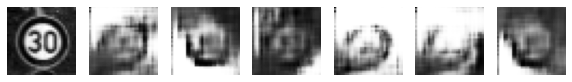

Epoch 891 g_loss= 2.1728048 d_loss= 0.3264274 real_acc= 0.86 fake_acc= 0.92
Epoch 892 g_loss= 2.0234199 d_loss= 0.29628187 real_acc= 0.82 fake_acc= 0.92
Epoch 893 g_loss= 1.5619936 d_loss= 0.4115001 real_acc= 0.88 fake_acc= 0.8
Epoch 894 g_loss= 1.9445062 d_loss= 0.31305882 real_acc= 0.86 fake_acc= 0.92
Epoch 895 g_loss= 2.6214037 d_loss= 0.26499045 real_acc= 0.84 fake_acc= 0.96
Epoch 896 g_loss= 2.1778212 d_loss= 0.41066742 real_acc= 0.78 fake_acc= 0.82
Epoch 897 g_loss= 2.4201243 d_loss= 0.34868628 real_acc= 0.82 fake_acc= 0.94
Epoch 898 g_loss= 2.1803722 d_loss= 0.3809703 real_acc= 0.82 fake_acc= 0.88
Epoch 899 g_loss= 1.8022625 d_loss= 0.36407188 real_acc= 0.8 fake_acc= 0.8
Epoch 900 g_loss= 1.7700458 d_loss= 0.41560885 real_acc= 0.88 fake_acc= 0.76


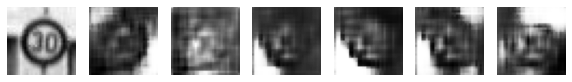

Epoch 901 g_loss= 1.803625 d_loss= 0.39936772 real_acc= 0.84 fake_acc= 0.76
Epoch 902 g_loss= 2.2790136 d_loss= 0.37550625 real_acc= 0.74 fake_acc= 0.98
Epoch 903 g_loss= 2.2026181 d_loss= 0.4435127 real_acc= 0.76 fake_acc= 0.92
Epoch 904 g_loss= 1.7722116 d_loss= 0.38608986 real_acc= 0.84 fake_acc= 0.86
Epoch 905 g_loss= 1.6302099 d_loss= 0.45052862 real_acc= 0.86 fake_acc= 0.72
Epoch 906 g_loss= 1.6028905 d_loss= 0.43904665 real_acc= 0.84 fake_acc= 0.76
Epoch 907 g_loss= 2.1922824 d_loss= 0.3672651 real_acc= 0.8 fake_acc= 0.92
Epoch 908 g_loss= 2.8901093 d_loss= 0.48999834 real_acc= 0.6 fake_acc= 0.92
Epoch 909 g_loss= 1.4422356 d_loss= 0.44780612 real_acc= 0.82 fake_acc= 0.76
Epoch 910 g_loss= 1.4084477 d_loss= 0.41590703 real_acc= 0.84 fake_acc= 0.76


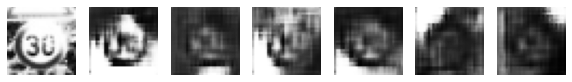

Epoch 911 g_loss= 1.5550723 d_loss= 0.4302141 real_acc= 0.8 fake_acc= 0.72
Epoch 912 g_loss= 2.307762 d_loss= 0.636373 real_acc= 0.68 fake_acc= 0.88
Epoch 913 g_loss= 2.0470994 d_loss= 0.6611632 real_acc= 0.64 fake_acc= 0.94
Epoch 914 g_loss= 1.1827849 d_loss= 0.50271285 real_acc= 0.88 fake_acc= 0.6
Epoch 915 g_loss= 1.041017 d_loss= 0.57558316 real_acc= 0.88 fake_acc= 0.52
Epoch 916 g_loss= 2.1770442 d_loss= 0.45692003 real_acc= 0.76 fake_acc= 0.88
Epoch 917 g_loss= 2.7556868 d_loss= 0.44456148 real_acc= 0.62 fake_acc= 1.0
Epoch 918 g_loss= 2.2406294 d_loss= 0.6493122 real_acc= 0.62 fake_acc= 0.94
Epoch 919 g_loss= 1.2949027 d_loss= 0.45707008 real_acc= 0.94 fake_acc= 0.64
Epoch 920 g_loss= 0.98760545 d_loss= 0.5922463 real_acc= 0.92 fake_acc= 0.42


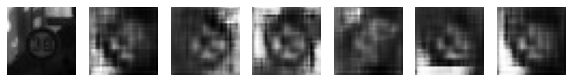

Epoch 921 g_loss= 1.8260314 d_loss= 0.43219507 real_acc= 0.9 fake_acc= 0.78
Epoch 922 g_loss= 2.8521166 d_loss= 0.58496755 real_acc= 0.64 fake_acc= 0.9
Epoch 923 g_loss= 2.6400378 d_loss= 0.44766623 real_acc= 0.66 fake_acc= 0.98
Epoch 924 g_loss= 2.2122316 d_loss= 0.26950434 real_acc= 0.9 fake_acc= 0.92
Epoch 925 g_loss= 1.5880209 d_loss= 0.39319062 real_acc= 0.82 fake_acc= 0.78
Epoch 926 g_loss= 1.6760528 d_loss= 0.38369793 real_acc= 0.92 fake_acc= 0.74
Epoch 927 g_loss= 2.0154572 d_loss= 0.2974559 real_acc= 0.86 fake_acc= 0.9
Epoch 928 g_loss= 2.1241665 d_loss= 0.36933243 real_acc= 0.82 fake_acc= 0.98
Epoch 929 g_loss= 2.8042054 d_loss= 0.45889175 real_acc= 0.68 fake_acc= 0.96
Epoch 930 g_loss= 2.0566847 d_loss= 0.3878522 real_acc= 0.8 fake_acc= 0.88


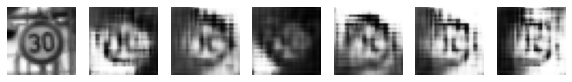

Epoch 931 g_loss= 1.5087003 d_loss= 0.44243056 real_acc= 0.78 fake_acc= 0.74
Epoch 932 g_loss= 1.2229278 d_loss= 0.48998654 real_acc= 0.8 fake_acc= 0.72
Epoch 933 g_loss= 2.0894458 d_loss= 0.37014204 real_acc= 0.8 fake_acc= 0.9
Epoch 934 g_loss= 2.9464202 d_loss= 0.3612103 real_acc= 0.76 fake_acc= 1.0
Epoch 935 g_loss= 2.3827536 d_loss= 0.40869337 real_acc= 0.74 fake_acc= 0.98
Epoch 936 g_loss= 1.4721755 d_loss= 0.33629107 real_acc= 0.88 fake_acc= 0.78
Epoch 937 g_loss= 1.4390851 d_loss= 0.46905124 real_acc= 0.84 fake_acc= 0.84
Epoch 938 g_loss= 1.8436279 d_loss= 0.4762811 real_acc= 0.72 fake_acc= 0.76
Epoch 939 g_loss= 2.5243497 d_loss= 0.41653427 real_acc= 0.8 fake_acc= 0.94
Epoch 940 g_loss= 2.7215803 d_loss= 0.46280774 real_acc= 0.7 fake_acc= 1.0


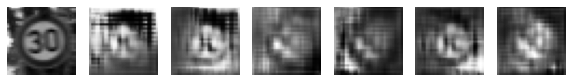

Epoch 941 g_loss= 1.6771798 d_loss= 0.48303005 real_acc= 0.88 fake_acc= 0.7
Epoch 942 g_loss= 1.7213418 d_loss= 0.49169505 real_acc= 0.86 fake_acc= 0.68
Epoch 943 g_loss= 2.2969396 d_loss= 0.39894074 real_acc= 0.84 fake_acc= 0.78
Epoch 944 g_loss= 3.9402845 d_loss= 0.51202494 real_acc= 0.7 fake_acc= 1.0
Epoch 945 g_loss= 3.177259 d_loss= 0.48957002 real_acc= 0.66 fake_acc= 0.96
Epoch 946 g_loss= 1.7980416 d_loss= 0.4258119 real_acc= 0.78 fake_acc= 0.78
Epoch 947 g_loss= 1.0197434 d_loss= 0.59216255 real_acc= 1.0 fake_acc= 0.36
Epoch 948 g_loss= 1.7024512 d_loss= 0.3289279 real_acc= 0.88 fake_acc= 0.9
Epoch 949 g_loss= 3.5683978 d_loss= 0.4921272 real_acc= 0.72 fake_acc= 0.98
Epoch 950 g_loss= 3.9790277 d_loss= 0.4204191 real_acc= 0.74 fake_acc= 1.0


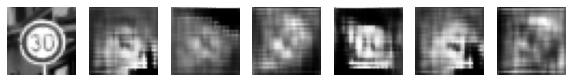

Epoch 951 g_loss= 2.952142 d_loss= 0.20576905 real_acc= 0.88 fake_acc= 0.96
Epoch 952 g_loss= 1.7586881 d_loss= 0.29531753 real_acc= 0.94 fake_acc= 0.74
Epoch 953 g_loss= 1.4908901 d_loss= 0.3736207 real_acc= 0.96 fake_acc= 0.6
Epoch 954 g_loss= 2.0276244 d_loss= 0.24524447 real_acc= 0.96 fake_acc= 0.84
Epoch 955 g_loss= 3.4330566 d_loss= 0.24944288 real_acc= 0.86 fake_acc= 1.0
Epoch 956 g_loss= 4.2608557 d_loss= 0.37090713 real_acc= 0.72 fake_acc= 1.0
Epoch 957 g_loss= 3.757734 d_loss= 0.28692 real_acc= 0.82 fake_acc= 1.0
Epoch 958 g_loss= 2.6022155 d_loss= 0.22889203 real_acc= 0.92 fake_acc= 0.96
Epoch 959 g_loss= 2.0459826 d_loss= 0.25448176 real_acc= 0.98 fake_acc= 0.76
Epoch 960 g_loss= 1.818945 d_loss= 0.2546695 real_acc= 1.0 fake_acc= 0.74


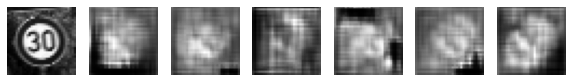

Epoch 961 g_loss= 2.0306966 d_loss= 0.20818932 real_acc= 0.98 fake_acc= 0.86
Epoch 962 g_loss= 3.3488379 d_loss= 0.21654457 real_acc= 0.84 fake_acc= 0.98
Epoch 963 g_loss= 4.074874 d_loss= 0.30248353 real_acc= 0.74 fake_acc= 1.0
Epoch 964 g_loss= 3.5424292 d_loss= 0.20953792 real_acc= 0.9 fake_acc= 0.96
Epoch 965 g_loss= 2.295337 d_loss= 0.22317865 real_acc= 0.94 fake_acc= 0.94
Epoch 966 g_loss= 2.03768 d_loss= 0.2456809 real_acc= 0.96 fake_acc= 0.86
Epoch 967 g_loss= 2.05183 d_loss= 0.19982915 real_acc= 0.96 fake_acc= 0.9
Epoch 968 g_loss= 2.1830554 d_loss= 0.21019508 real_acc= 0.92 fake_acc= 0.92
Epoch 969 g_loss= 2.4716299 d_loss= 0.2070437 real_acc= 0.94 fake_acc= 0.98
Epoch 970 g_loss= 3.0700414 d_loss= 0.26215973 real_acc= 0.8 fake_acc= 1.0


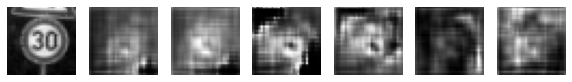

Epoch 971 g_loss= 2.5769432 d_loss= 0.2058163 real_acc= 0.86 fake_acc= 0.96
Epoch 972 g_loss= 2.608355 d_loss= 0.21130192 real_acc= 0.9 fake_acc= 0.98
Epoch 973 g_loss= 2.1067178 d_loss= 0.25752348 real_acc= 0.94 fake_acc= 0.9
Epoch 974 g_loss= 1.9699467 d_loss= 0.24118707 real_acc= 0.9 fake_acc= 0.92
Epoch 975 g_loss= 2.1302423 d_loss= 0.19356272 real_acc= 0.96 fake_acc= 0.92
Epoch 976 g_loss= 2.4529607 d_loss= 0.20317757 real_acc= 0.92 fake_acc= 0.94
Epoch 977 g_loss= 2.7338314 d_loss= 0.21367621 real_acc= 0.86 fake_acc= 0.98
Epoch 978 g_loss= 2.9559207 d_loss= 0.18855523 real_acc= 0.8 fake_acc= 1.0
Epoch 979 g_loss= 2.6547074 d_loss= 0.2139912 real_acc= 0.84 fake_acc= 1.0
Epoch 980 g_loss= 2.4352736 d_loss= 0.2710797 real_acc= 0.84 fake_acc= 0.96


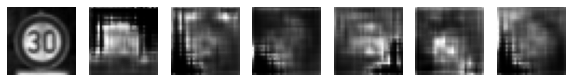

Epoch 981 g_loss= 2.041902 d_loss= 0.22838259 real_acc= 0.88 fake_acc= 0.92
Epoch 982 g_loss= 1.9127421 d_loss= 0.24073814 real_acc= 0.92 fake_acc= 0.84
Epoch 983 g_loss= 1.8571919 d_loss= 0.2538696 real_acc= 0.9 fake_acc= 0.92
Epoch 984 g_loss= 2.6303518 d_loss= 0.22428975 real_acc= 0.88 fake_acc= 0.98
Epoch 985 g_loss= 2.3885705 d_loss= 0.25959733 real_acc= 0.8 fake_acc= 0.92
Epoch 986 g_loss= 2.6192863 d_loss= 0.22149816 real_acc= 0.86 fake_acc= 0.96
Epoch 987 g_loss= 2.2778833 d_loss= 0.22089005 real_acc= 0.92 fake_acc= 0.96
Epoch 988 g_loss= 2.5283573 d_loss= 0.21983439 real_acc= 0.88 fake_acc= 0.98
Epoch 989 g_loss= 2.1050243 d_loss= 0.36619228 real_acc= 0.88 fake_acc= 0.8
Epoch 990 g_loss= 1.8309616 d_loss= 0.4612044 real_acc= 0.88 fake_acc= 0.72


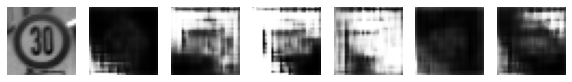

Epoch 991 g_loss= 2.8332338 d_loss= 0.7104596 real_acc= 0.74 fake_acc= 0.86
Epoch 992 g_loss= 3.7781823 d_loss= 0.7722739 real_acc= 0.56 fake_acc= 0.88
Epoch 993 g_loss= 3.9360743 d_loss= 0.664353 real_acc= 0.64 fake_acc= 0.86
Epoch 994 g_loss= 3.4208124 d_loss= 0.62485737 real_acc= 0.66 fake_acc= 0.9
Epoch 995 g_loss= 2.4683378 d_loss= 0.5088573 real_acc= 0.68 fake_acc= 0.84
Epoch 996 g_loss= 2.0888124 d_loss= 0.2727832 real_acc= 0.88 fake_acc= 0.84
Epoch 997 g_loss= 1.9964736 d_loss= 0.31327102 real_acc= 0.94 fake_acc= 0.74
Epoch 998 g_loss= 2.9538507 d_loss= 0.24584045 real_acc= 0.92 fake_acc= 0.9
Epoch 999 g_loss= 3.8272345 d_loss= 0.20741452 real_acc= 0.88 fake_acc= 0.98
Done


In [18]:
epochs = 1000
for epoch in range(epochs):
    # take some random samples
    new_samples = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples)
    
    if epoch % 10 == 0:
        # show one real image and some fake images generated by generator using noise seed
        #display.clear_output(wait=True)
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(samples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()    
print("Done")

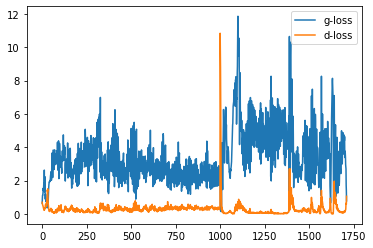

In [15]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

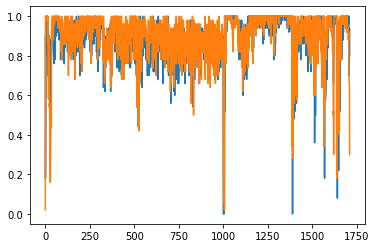

In [16]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.show()